# Proyecto Series de Tiempo Univariadas
El siguiente Script abarca las metodologías vistas en el semestre 2024-1 de Series de Tiempo Univariadas desarrolladas en Python, utilizando la medición de la tasa de desempleo en Colombia; desde enero de 2001 hasta diciembre de 2023.

#### Integrantes: Anderson Guarín, Ander Cristancho, Juan Duitama

## Librerías utilizadas

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import scipy.stats 
import plotly.graph_objects as go
from pandas import read_csv
from matplotlib import pyplot
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import timedelta
import tensorflow.keras as keras
import keras_tuner as kt
from tensorflow.keras import layers
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
rcParams['figure.figsize'] = 15, 10
register_matplotlib_converters()

## Importación base de datos

In [3]:
import os
#Directorio Yo
os.chdir("D:\Estadística\Semestres\Semestre 9\Series de Tiempo Univariadas\Datos")
#Directorio Ander
#os.chdir(r"C:\Users\EQUIPO\OneDrive\Documentos\Documentos Ander\UNAL\Series de tiempo\Mis series y descriptiva")
os.getcwd()

'D:\\Estadística\\Semestres\\Semestre 9\\Series de Tiempo Univariadas\\Datos'

In [4]:
Data = pd.read_excel("Desempleo.xlsx",skiprows=5,nrows=277)
Data = Data.iloc[:,[0,2]]
print(Data.dtypes)
# Cambiar los nombres de las columnas
nuevos_nombres = ['AnioMes', 'TasaDesempleo']
Data.columns = nuevos_nombres
Data

Año-Mes (AAAA-MM)         object
Tasa de desempleo (%)    float64
dtype: object


AnioMes  TasaDesempleo
0    2023-12      10.013717
1    2023-11       9.007386
2    2023-10       9.230912
3    2023-09       9.252674
4    2023-08       9.277372
..       ...            ...
271  2001-05      14.035800
272  2001-04      14.515100
273  2001-03      15.811900
274  2001-02      17.434200
275  2001-01      16.622300

[276 rows x 2 columns]

In [5]:
%qtconsole

## Gráfica de la tasa de desempleo en Colombia

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


Text(0.5, 1.0, 'Tasa de desempleo mensual en Colombia')

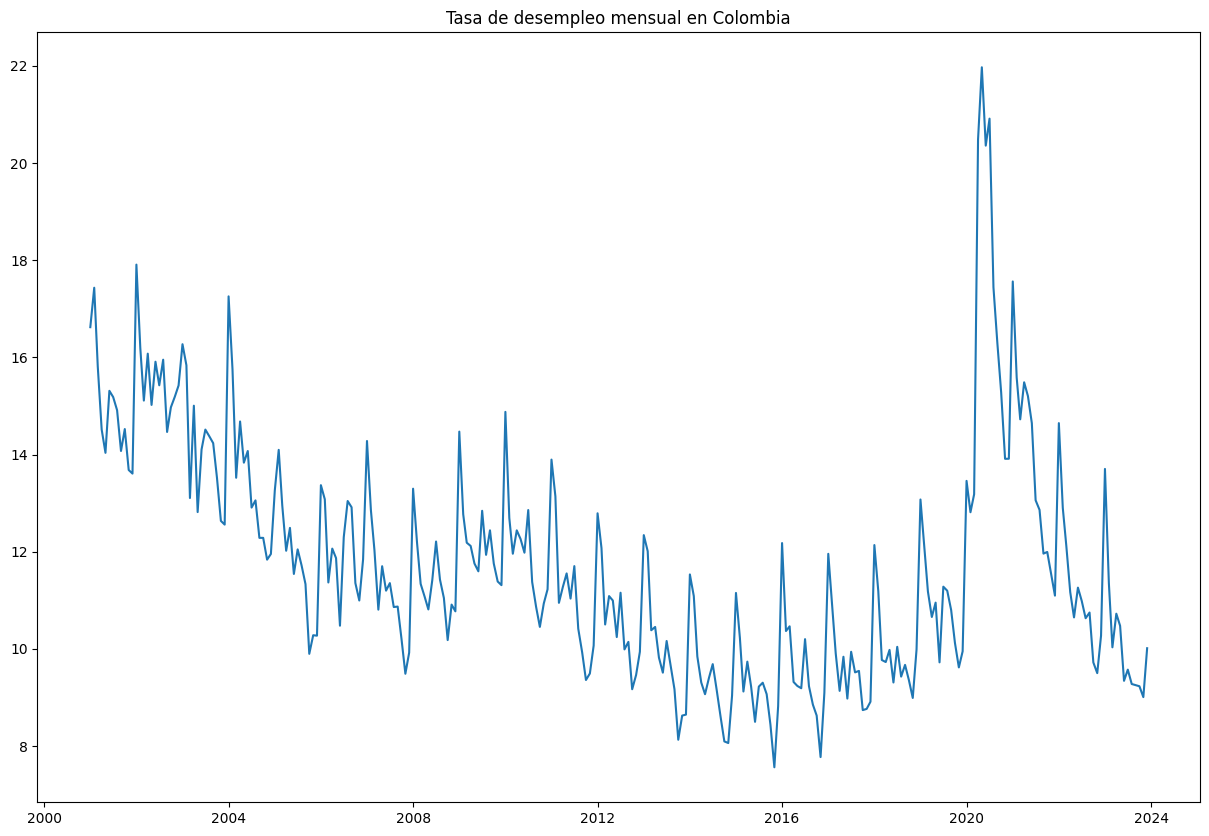

In [6]:
#Primera observación de los datos
Data['AnioMes']=pd.to_datetime(Data['AnioMes'])#Convirtiendo la columna año y mes a formato fecha
Desempleo1=Data.set_index('AnioMes')#Ordenando el dataframe, pero creo uno nuevo para volverlo objeto de series de tiempo luego
print(type(Desempleo1))
#Convirtiendo el data frame en objeto serie de tiempo
DesempleoTS=Desempleo1['TasaDesempleo']
print(type(DesempleoTS))
plt.plot(DesempleoTS)#Haciendo un primer gráfico de la serie de tiempo
plt.title('Tasa de desempleo mensual en Colombia') 

### Gráfico Interactivo

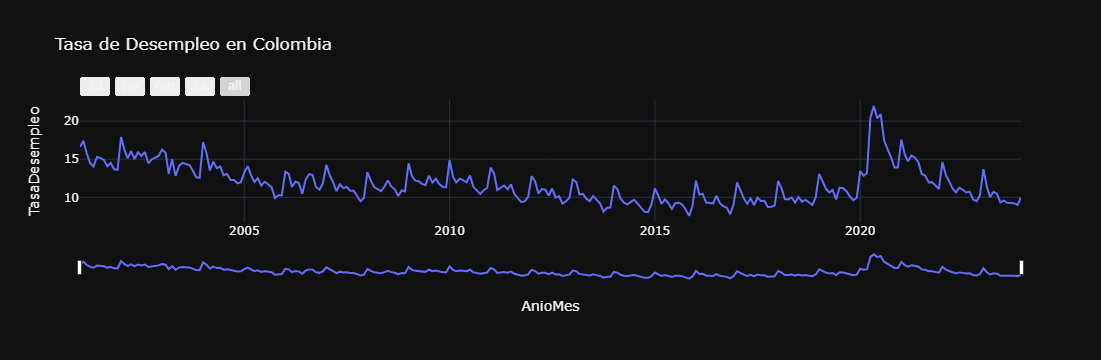

In [7]:
#Haciendo un gráfico interactivo ahora
# Crea un gráfico de líneas
fig = px.line(DesempleoTS, y="TasaDesempleo",title="Tasa de Desempleo en Colombia",template='plotly_dark')#Se le puede quitar el modo oscuro si quiere
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


## Autocorrelación
Un primer gráfico de la autocorrelación, recordemos que no es válido hasta que retiremos la tendencia y la estacionalidad

(0.0, 20.0)

array([ 1.        ,  0.84607915,  0.72424958,  0.66588031,  0.61838167,
        0.59286438,  0.59155327,  0.53505398,  0.5047075 ,  0.48902489,
        0.47623169,  0.52237259,  0.59079687,  0.46866133,  0.37453414,
        0.3380772 ,  0.31601044,  0.30476275,  0.31462484,  0.2556188 ,
        0.22166647,  0.19622521,  0.18643978,  0.22830798,  0.29316694,
        0.18602571,  0.10540071,  0.0924295 ,  0.07822385,  0.07699178,
        0.09814316,  0.06191482,  0.03803485,  0.0193529 ,  0.01777681,
        0.0807484 ,  0.14822133,  0.05514637, -0.01960476, -0.03015742,
       -0.02589864])

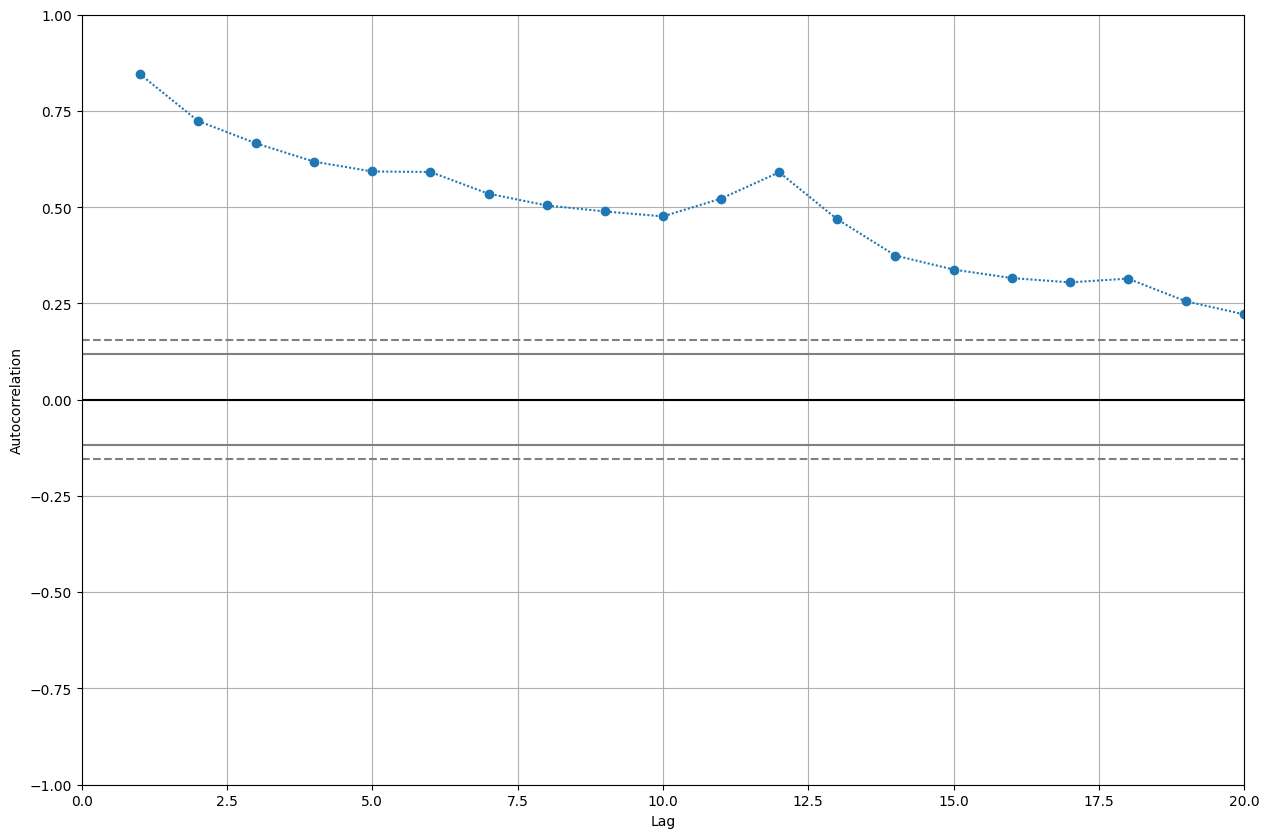

In [8]:
from pandas.plotting import autocorrelation_plot
ax =autocorrelation_plot(DesempleoTS,marker="o",dashes= (1,0,0,1))
ax.set_xlim([0, 20])
acf(DesempleoTS,adjusted=False,fft=False,nlags=40)###fft=FALSE es para quitar el warning

In [9]:
#Existe la posibilidad de hacer Downsampling, el cual consiste en convertir series de cierta frecuencia en series de menores frecuencias, esto 
#consiste en hacer operaciones con las observaciones, por ejemplo, se tiene una serie diaria y se suman de a 7 observaciones para obtener una nueva
#serie que sea semanal. Esto se logra con la siguiente función
#ts.resample('5min', closed='right').sum(), en este caso es una serie que se mide cada minuto y se suman de a 5 minutos.

# Análisis Descriptivo
En principio la serie aparenta tener un ciclo(estacionalidad) que se repite cada año, es decir, una serie con periodo doce, en la que el mayor pico que se tiene en cada año se encuentra localizado en el mes de enero, exceptuando el 2005 y la pandemia de 2020. En todos los demás años la mayor tasa de desempleo que se reportó ocurrió en enero, y en los meses posteriores fue reduciendo hasta crecer nuevamente finalizando el año. Parece haber una ligera tendencia decreciente desde el año 2001 hasta finales de 2019. El rango de los valores de la tasa de desempleo parece ser constante a simple vista, nuevamente exceptuando la pandemia.
## Estabilización de la varianza
A pesar de que el rango de valores de la tasa de desempleo en cada año parece ser constante, es decir, aparenta tener varianza constante, se realizará una transformación de los valores con el fin de evitar problemas futuros; en especial para el periodo posterior al 2019, cuyos valores se vieron afectados por el suceso ya conocido; Covid 19.
### Transformación Box-Cox

In [10]:
BoxCoxStat=sp.stats.boxcox(DesempleoTS,alpha=0.05)
BoxCoxStat[1]#Estimación de Lambda
BoxCoxStat[2]#Intervalo de Confianza para Lambda
type(DesempleoTS)

-1.0217146799966539

(-1.5793106877650602, -0.4772510131365414)

pandas.core.series.Series

In [11]:
TranDesempleoTS=sp.stats.boxcox(Data['TasaDesempleo'],lmbda=BoxCoxStat[1])#Transformando los datos
Desempleo1 = Desempleo1.assign(DesempleoTransf=TranDesempleoTS)#Creo una nueva columna en el dataframe que le puse como indice la fecha, con los datos transformados   
TranDesempleoTS= Desempleo1['DesempleoTransf']  #Esto es un nuevo objeto de series de tiempo, pero solo con la columna de la tasa de desempleo transformada

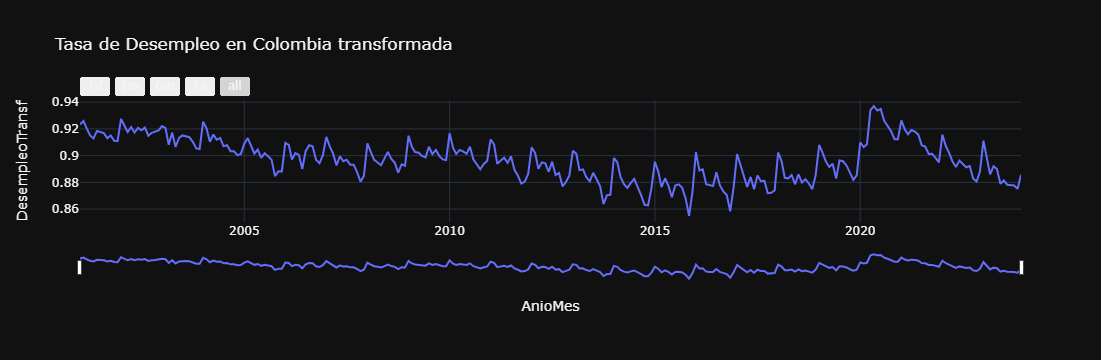

In [12]:
#Gráfico de los datos transformados
fig2 = px.line(TranDesempleoTS, y="DesempleoTransf",title="Tasa de Desempleo en Colombia transformada",template='plotly_dark')#Se le puede quitar el modo oscuro si quiere
fig2.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)


## Cálculo y estimación de la función de autocorrelación
No hemos retirado la tendencia, solo se han transformado los datos, por lo tanto, no se espera un cambio.

(0.0, 20.0)

array([1.        , 0.84341503, 0.70900019, 0.64781178, 0.63287266,
       0.63562853, 0.65098155, 0.58827337, 0.54324536, 0.51552879,
       0.53351346, 0.61954851, 0.7086666 , 0.58117998, 0.45809467,
       0.39753504, 0.38311918, 0.38296744, 0.4045556 , 0.33907415,
       0.2929265 , 0.26045852, 0.27227872, 0.3507019 , 0.43128193,
       0.31262066, 0.19525349, 0.14907517, 0.1397739 , 0.14807481,
       0.17682308, 0.12919836, 0.09226009, 0.06727985, 0.08360044,
       0.17403368, 0.25596641, 0.15091852, 0.03908449, 0.00147295,
       0.0036992 ])

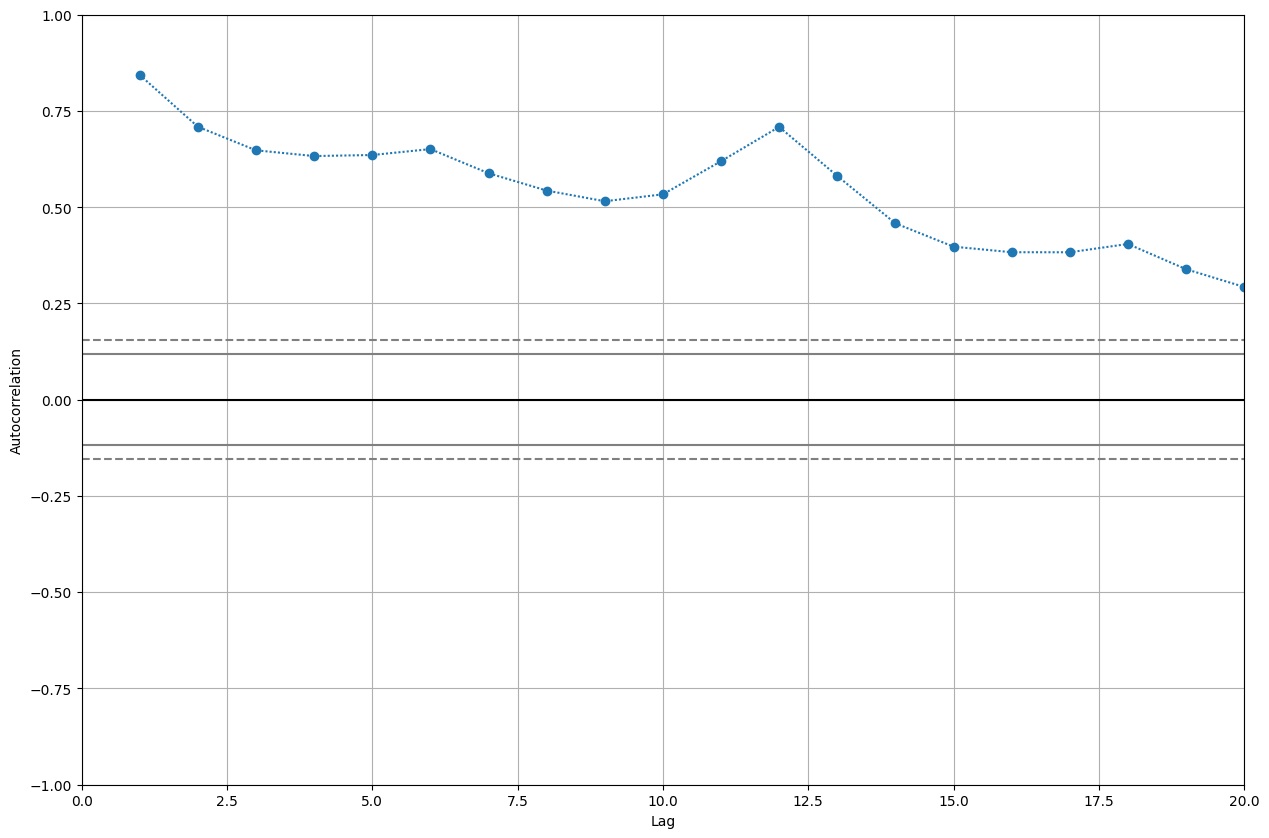

In [13]:
ax =autocorrelation_plot(TranDesempleoTS,marker="o",dashes= (1,0,0,1))
ax.set_xlim([0, 20])
acf(TranDesempleoTS,adjusted=False,fft=False,nlags=40)###fft=FALSE es para quitar el warning

## Extracción de la tendencia
La función seasonal_decompose, descompone la seri de tiempo original en 3 partes, componente de tendencia, componente de estacionalidad y la componente residual. La estracción de la componente de tendencia se realiza con promedios móviles.
### Descomposición utilizando promedio móvil para extraer la tendencia

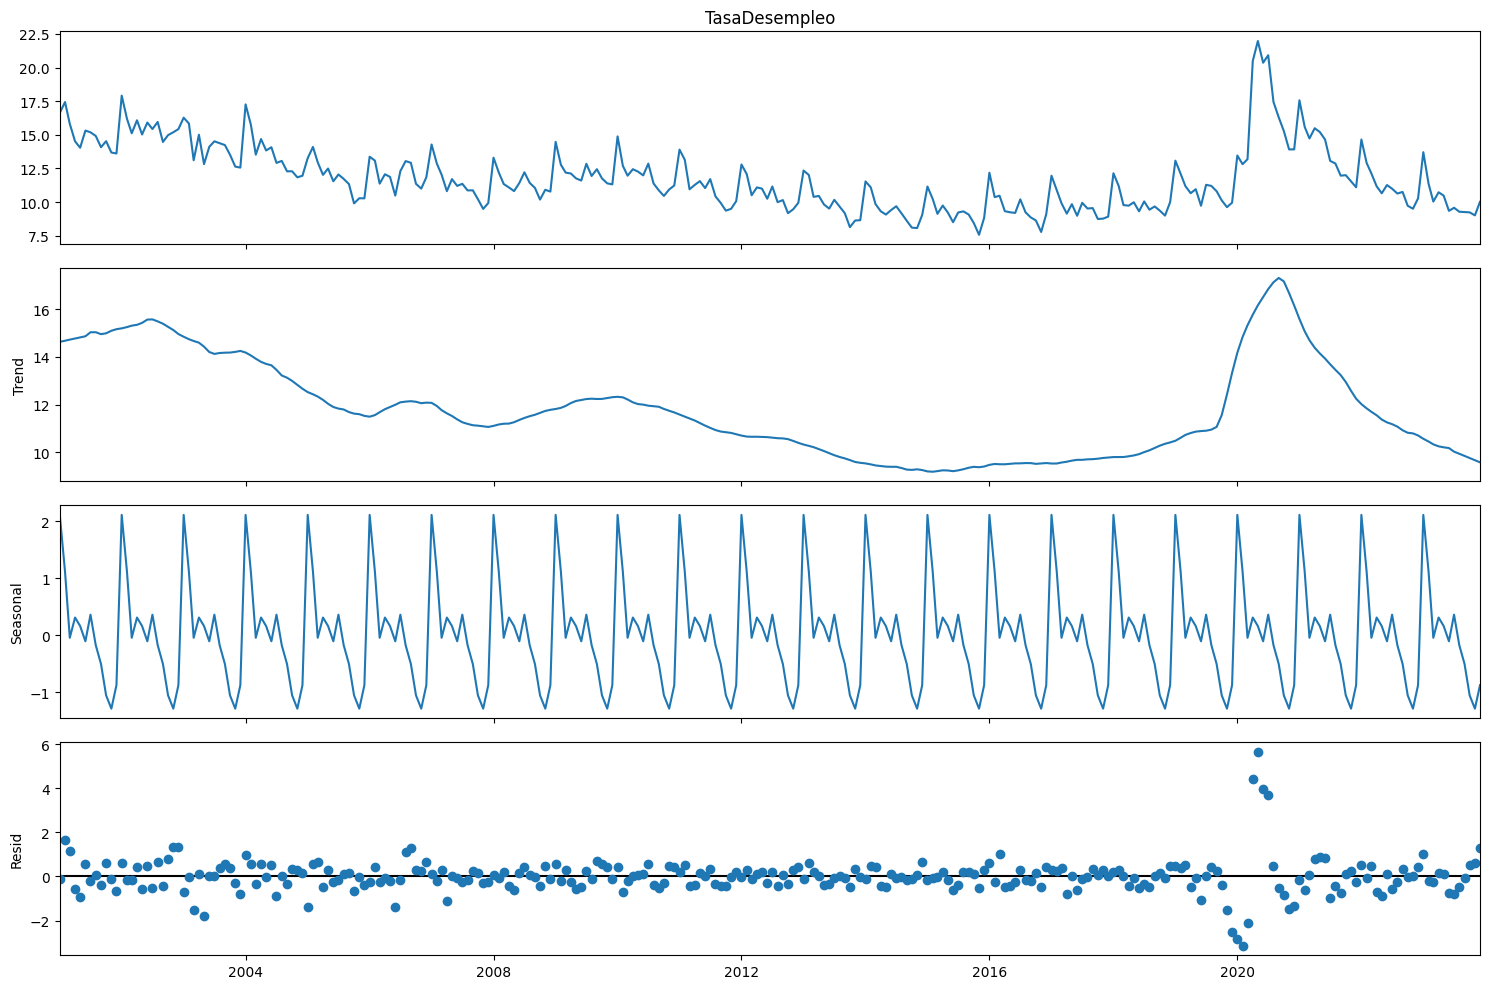

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

###También se puede hacer vía STL###
Descomp = seasonal_decompose(DesempleoTS, model='additive',extrapolate_trend=6)

descomposicion_Desempleo=Descomp.plot()
descomposicion_Desempleo.gca().invert_xaxis()#Me estaba mostrando el eje x invertido
pyplot.show()


### Extracción de la tendencia con regresión lineal

In [15]:
X1 = np.arange(2001, 2024, 1/12)#Creando un array que va desde enero de 2001 hasta diciembre de 2023
X=X1

LinearRegression()

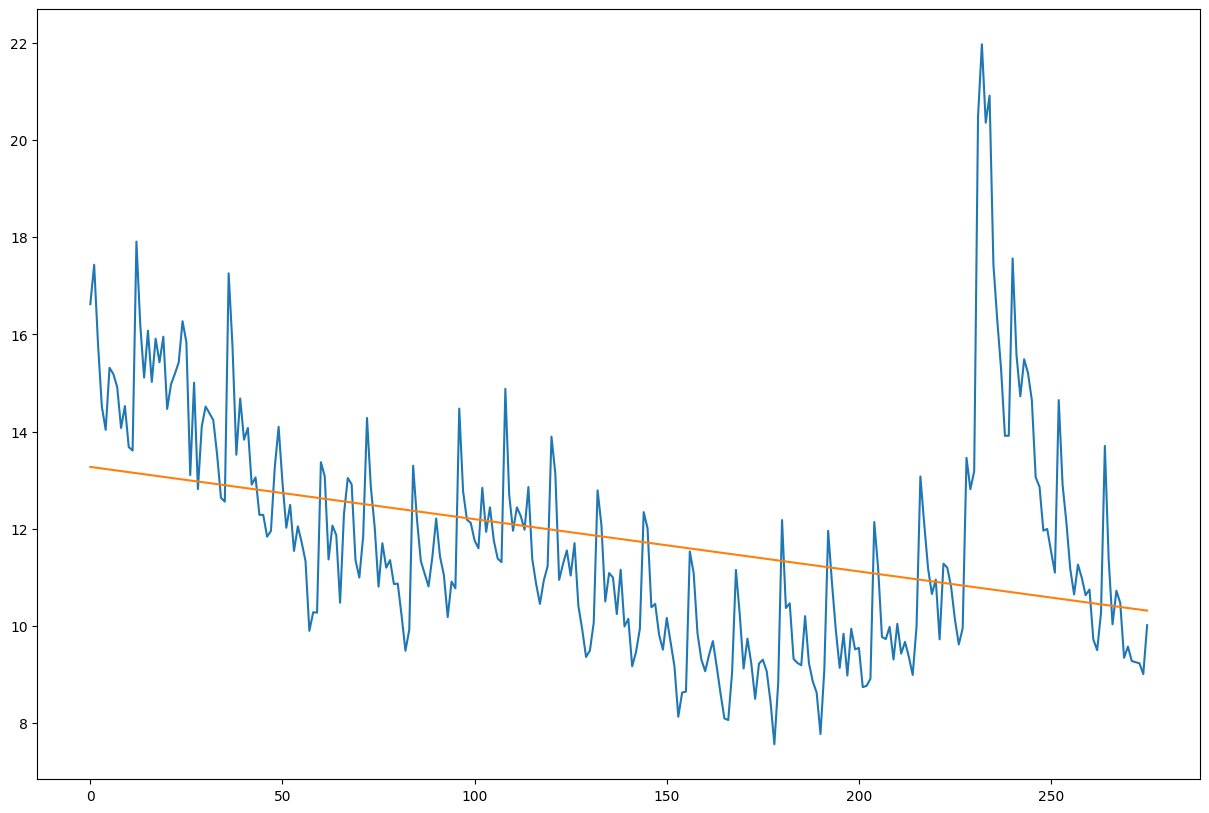

array([-0.12907341])

271.5482779525697

In [16]:
from sklearn.linear_model import LinearRegression
X = np.reshape(X, (len(X), 1))#convirtiendo X en una matriz de longitud de X por 1
y = DesempleoTS.values #Extrayendo solo las observaciones de la serie de Desempleo
y = y[::-1]#No sé por qué me invierte los y de orden si ya estaban ordenados arriba
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()
model.coef_
model.intercept_

Se encuentran los y estimados, luego se restan con las observaciones reales, es decir, se está eliminando la tendencia.

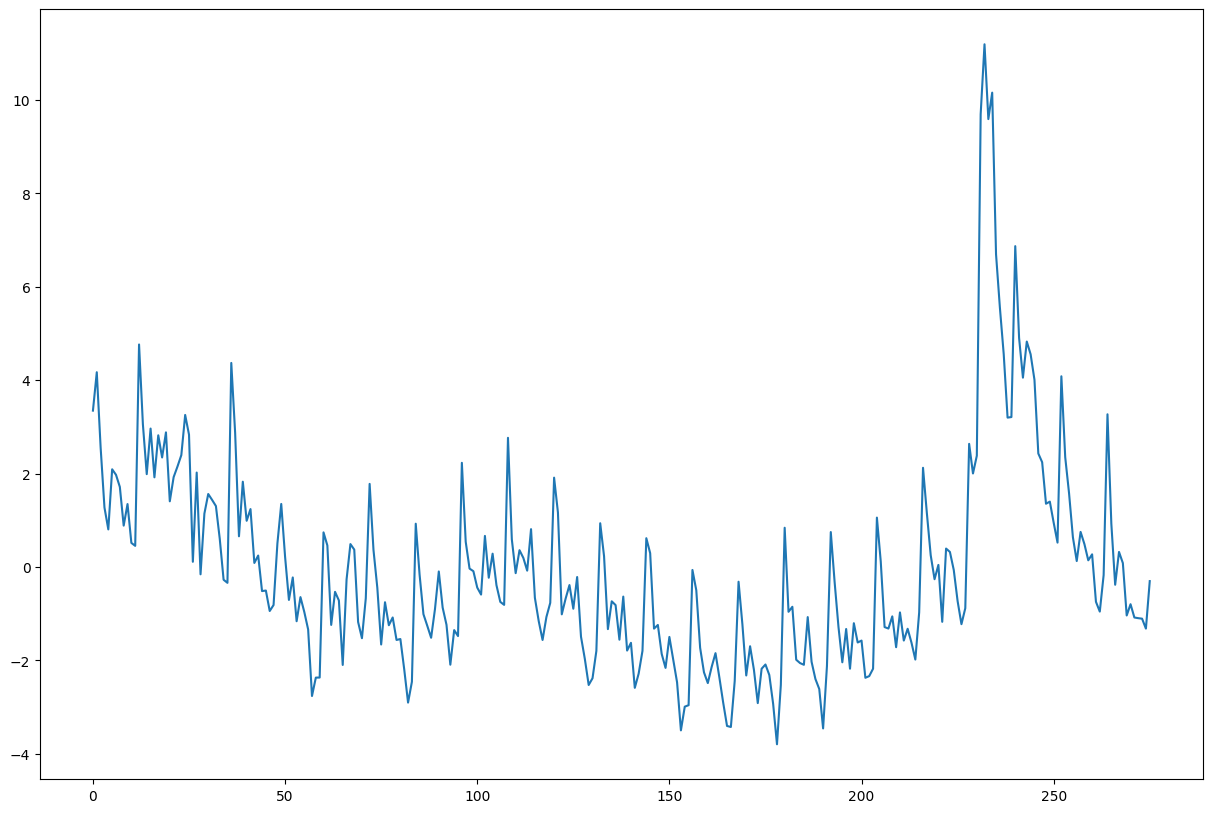

In [17]:
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(DesempleoTS))]
# plot detrended
plt.plot(detrended)
plt.show()
Desempleo_detrend=pd.Series(detrended,index=DesempleoTS.index)

In [18]:
X = sm.add_constant(X)
linmodel = sm.OLS(y, X)
results = linmodel.fit()
print(results.summary())
ypred = results.predict(X)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     38.72
Date:                Tue, 11 Jun 2024   Prob (F-statistic):           1.83e-09
Time:                        11:23:48   Log-Likelihood:                -619.07
No. Observations:                 276   AIC:                             1242.
Df Residuals:                     274   BIC:                             1249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        271.5483     41.745      6.505      0.0

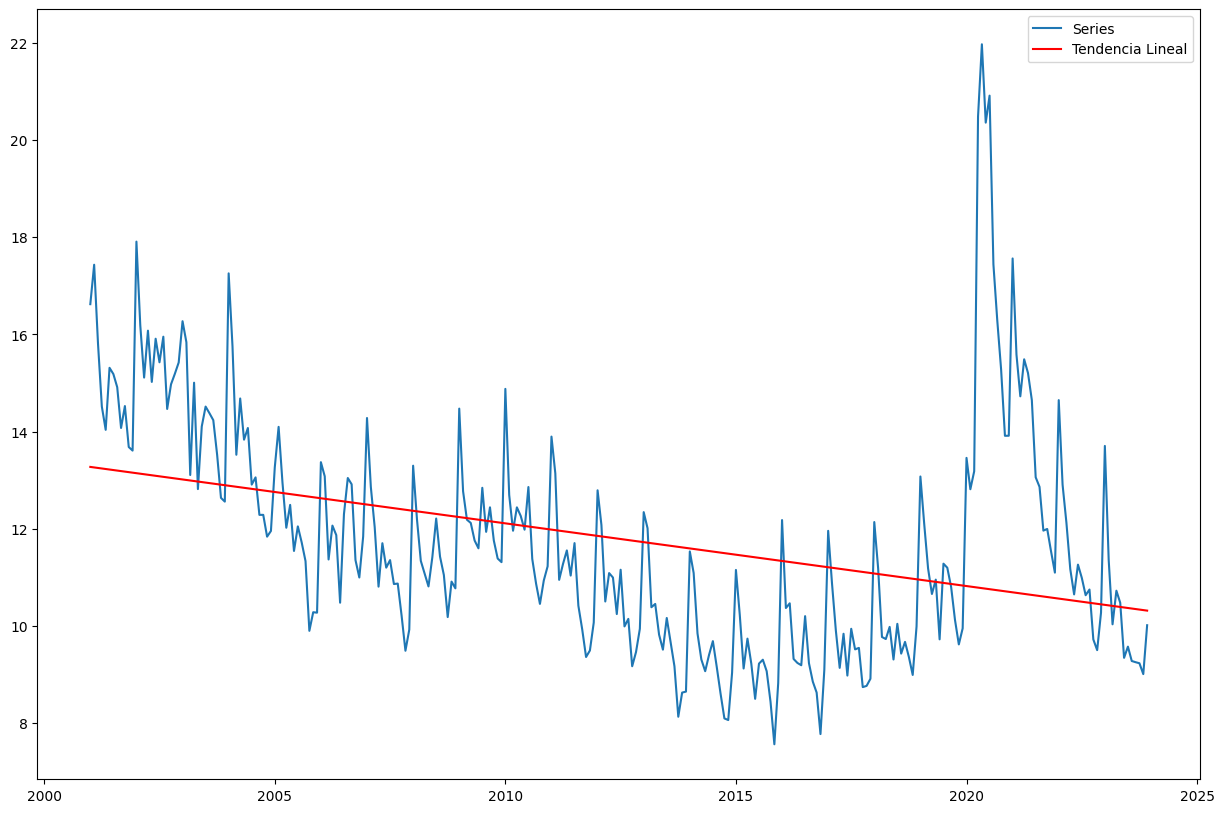

In [19]:
fig, ax = plt.subplots()
ax.plot(X1, y, '-', label="Series")
ax.plot(X1, ypred, 'r', label="Tendencia Lineal")
ax.legend(loc="best");

### Extracción de la tendencia utilizando operador diferencia

In [20]:
#Encontré una diferencia con el trabajo que estamos haciendo en R, y es que el Lambda acá en Python es -1.02, pero en R es -1.3, por eso las dos series me dan distinto
DifeDesempleo=TranDesempleoTS.iloc[::-1].diff(periods=1)
DifeDesempleo

AnioMes
2001-01-01         NaN
2001-02-01    0.002634
2001-03-01   -0.005537
2001-04-01   -0.005327
2001-05-01   -0.002221
                ...   
2023-08-01   -0.003169
2023-09-01   -0.000274
2023-10-01   -0.000243
2023-11-01   -0.002562
2023-12-01    0.010625
Name: DesempleoTransf, Length: 276, dtype: float64

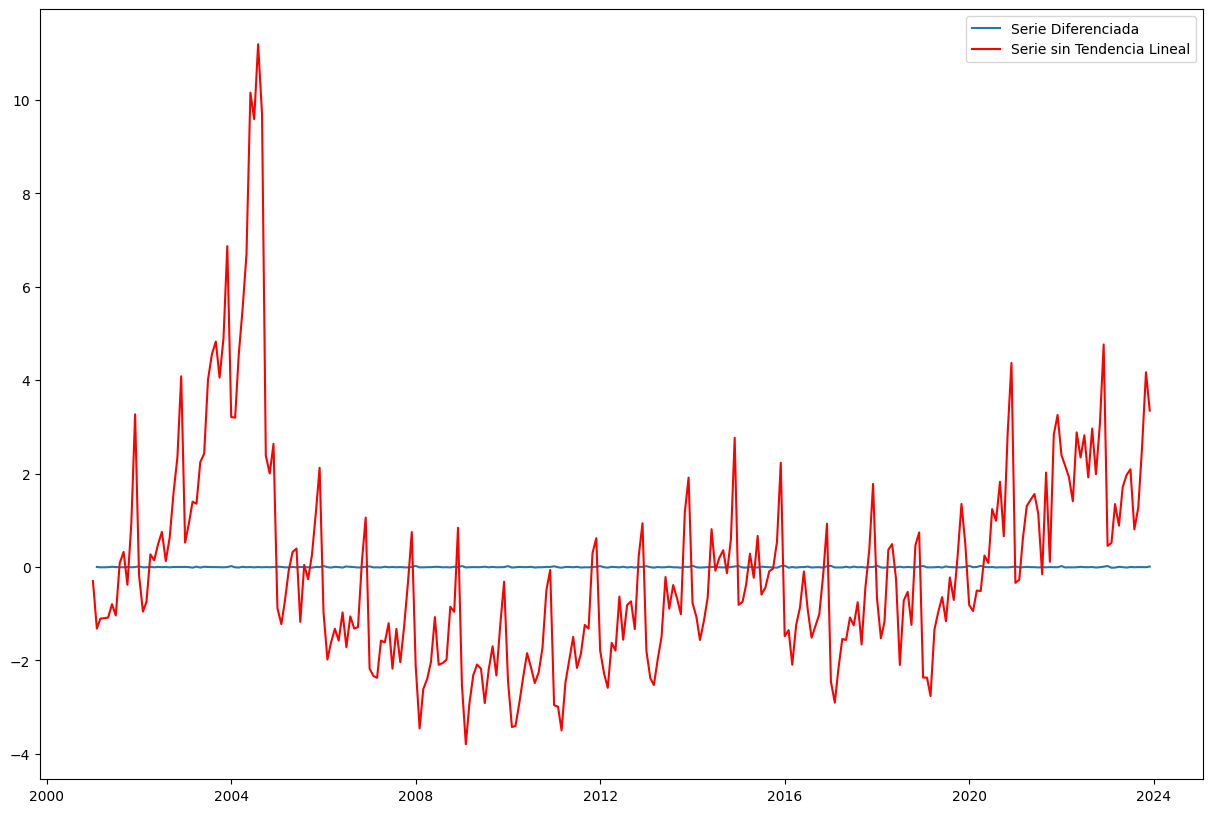

In [21]:
fig, ax = plt.subplots()
ax.plot(DifeDesempleo, '-', label="Serie Diferenciada")
ax.plot(Desempleo_detrend, 'r', label="Serie sin Tendencia Lineal")
ax.legend(loc="best");

### Gráficos de autocorrelación
A partir de este momento los gráficos correspondientes a la autocorrelación pueden realizarse, de mostrar algún patrón cíclico será indicio de la presencia de estacionalidad

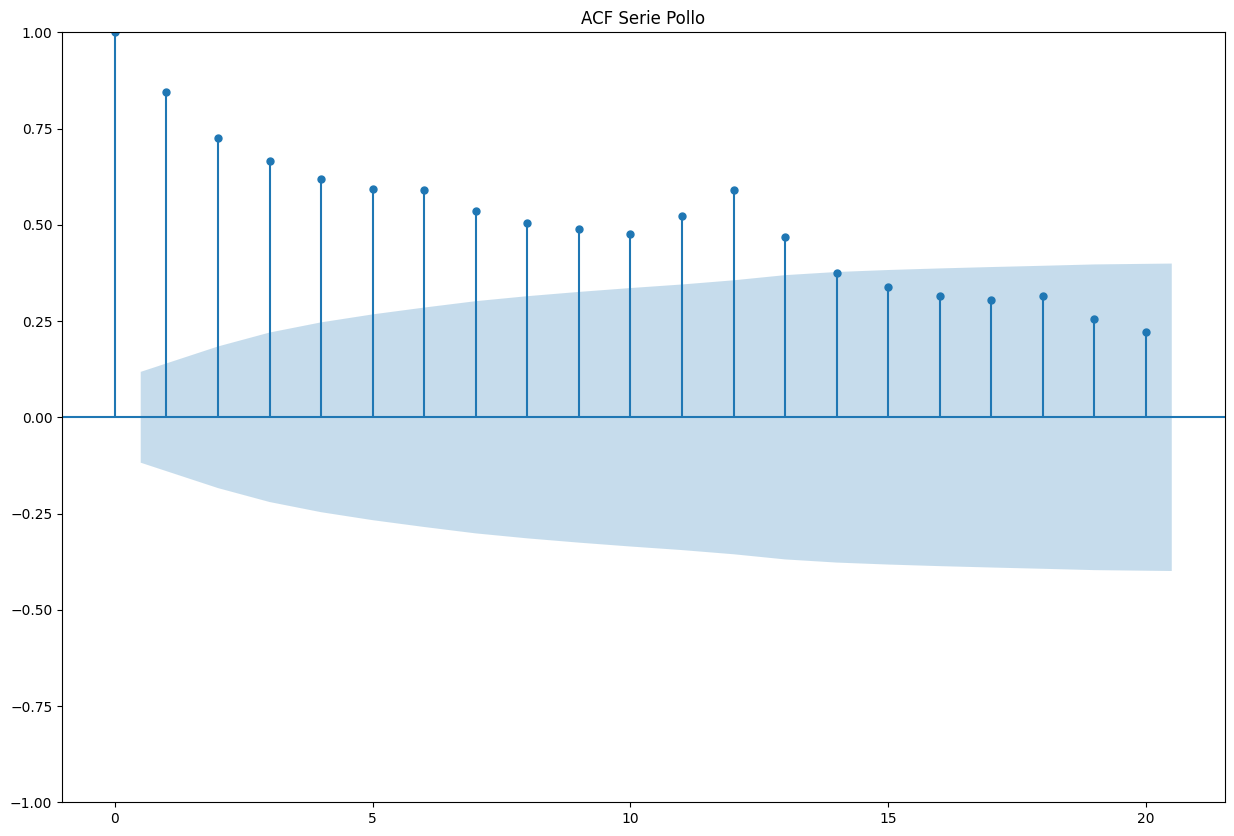

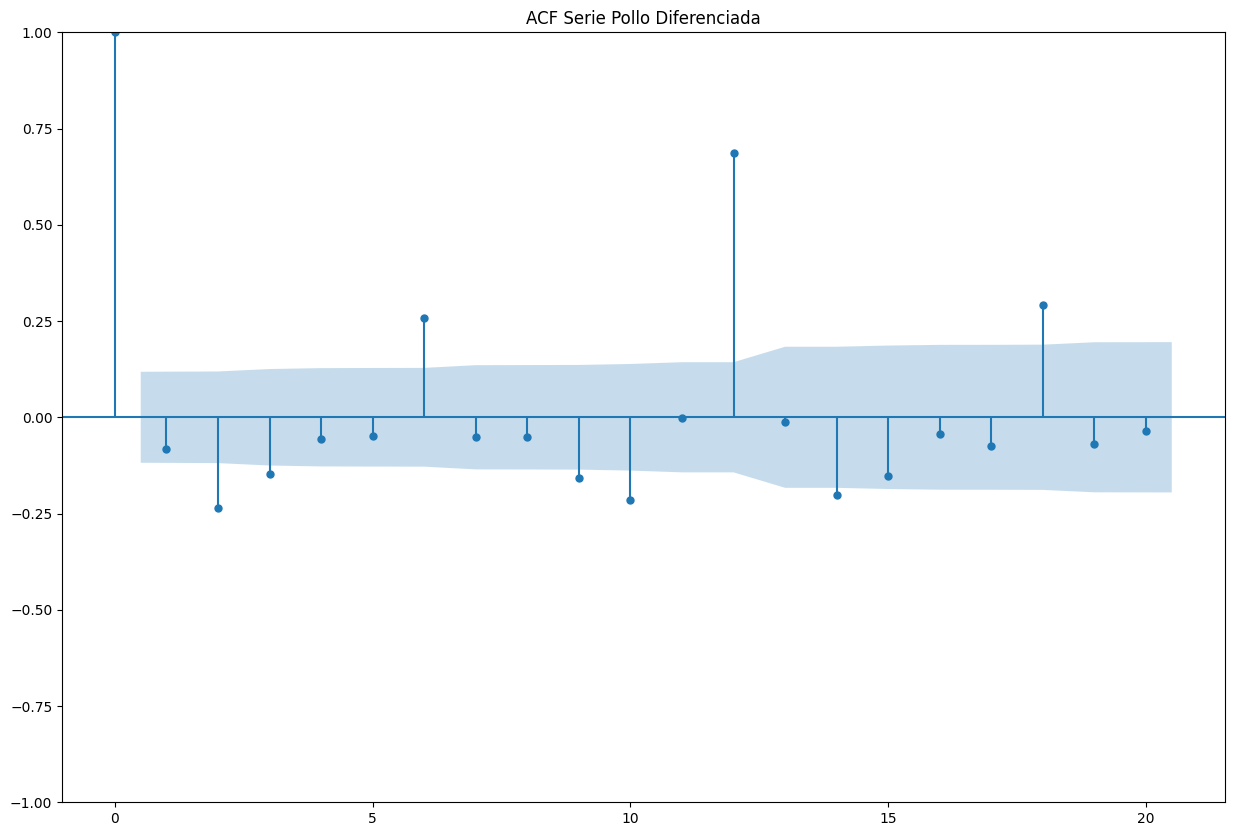

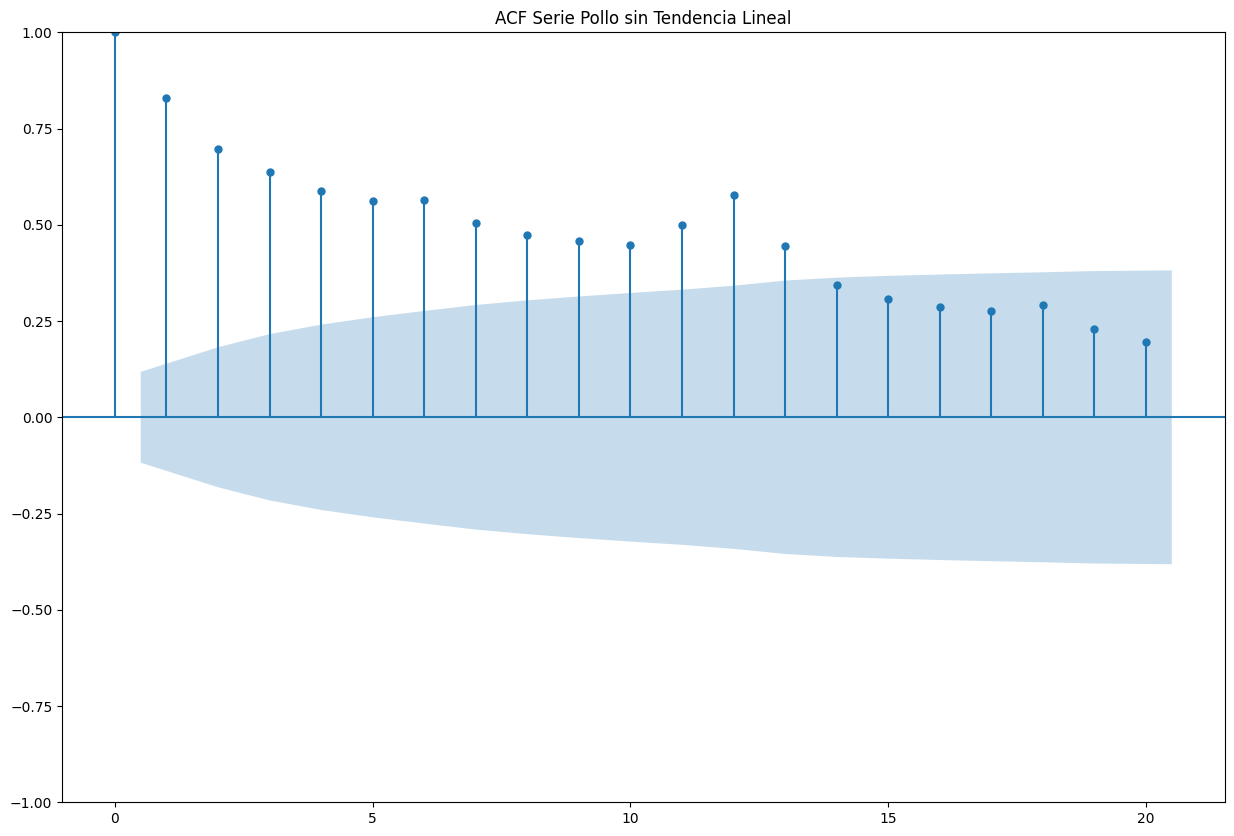

In [22]:
a=plot_acf(DesempleoTS,adjusted=False,lags=20,title='ACF Serie Pollo')
b=plot_acf(DifeDesempleo.dropna(),adjusted=False,lags=20,title='ACF Serie Pollo Diferenciada')
c=plot_acf(Desempleo_detrend,adjusted=False,lags=20,title='ACF Serie Pollo sin Tendencia Lineal')

# Modelamiento utilizando árboles 
Recordemos que utilizaremos la serie con la tendencia retirada, hemos trabajado con la serie diferenciada una vez.

In [23]:
DifeDesempleo
DifeDesempleo_DF = pd.DataFrame(DifeDesempleo.values,index=pd.date_range(start='2001-01-01', end='2023-12-01', freq='MS') )
DifeDesempleo_DF = DifeDesempleo_DF.iloc[1:]#Me deshago de la primera fila que no tiene observación
DifeDesempleo_DF

AnioMes
2001-01-01         NaN
2001-02-01    0.002634
2001-03-01   -0.005537
2001-04-01   -0.005327
2001-05-01   -0.002221
                ...   
2023-08-01   -0.003169
2023-09-01   -0.000274
2023-10-01   -0.000243
2023-11-01   -0.002562
2023-12-01    0.010625
Name: DesempleoTransf, Length: 276, dtype: float64

0
2001-02-01  0.002634
2001-03-01 -0.005537
2001-04-01 -0.005327
2001-05-01 -0.002221
2001-06-01  0.005603
...              ...
2023-08-01 -0.003169
2023-09-01 -0.000274
2023-10-01 -0.000243
2023-11-01 -0.002562
2023-12-01  0.010625

[275 rows x 1 columns]

Del trabajo anterior en R, los retardos que tenían mejor relación con la observación t son:
* t-2
* t-3
* t-4
* t-5
* t-6
* t-9
* t-10
* t-11
* t-12

Creación manual de los inputs y outputs

Inputs

In [24]:
from pandas import DataFrame
df1 = DataFrame()#Creando un DataFrame vacío para luego llenar
for i in range(12,8,-1):
    df1[['t-'+str(i)]] = DifeDesempleo_DF.shift(i)#El método shift() se encarga de desplazar las filas i veces hacia abajo, y al hacer
    
for i in range(6,1,-1):   
    df1[['t-'+str(i)]] = DifeDesempleo_DF.shift(i)

df1

t-12      t-11      t-10       t-9       t-6       t-5  \
2001-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-03-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-05-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-06-01       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-08-01 -0.002907  0.000974 -0.009349 -0.002271 -0.014307 -0.011013   
2023-09-01  0.000974 -0.009349 -0.002271  0.007526 -0.011013  0.006114   
2023-10-01 -0.009349 -0.002271  0.007526  0.023105  0.006114 -0.002111   
2023-11-01 -0.002271  0.007526  0.023105 -0.014307 -0.002111 -0.011014   
2023-12-01  0.007526  0.023105 -0.014307 -0.011013 -0.011014  0.002455   

                 t-4       t-3       t-2  
2001-02-01       NaN       NaN       NaN  
2001-03-01       NaN       NaN       NaN  
2001-04-01       NaN       NaN  0.002634  
2001-05-01       NaN  0.002634 -0.005537  
2001-06-01  0.002634 -0.005537 -0.005327  
...              ...       ...       ...  
2023-08-01  0.006114 -0.002111 -0.011014  
2023-09-01 -0.002111 -0.011014  0.002455  
2023-10-01 -0.011014  0.002455 -0.003169  
2023-11-01  0.002455 -0.003169 -0.000274  
2023-12-01 -0.003169 -0.000274 -0.000243  

[275 rows x 9 columns]

Outputs(Haremos la predicción un paso adelante)

In [25]:
df1['t'] = DifeDesempleo_DF.values
print(df1.head(13))

                t-12      t-11      t-10       t-9       t-6       t-5  \
2001-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-03-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-05-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-06-01       NaN       NaN       NaN       NaN       NaN       NaN   
2001-07-01       NaN       NaN       NaN       NaN       NaN  0.002634   
2001-08-01       NaN       NaN       NaN       NaN  0.002634 -0.005537   
2001-09-01       NaN       NaN       NaN       NaN -0.005537 -0.005327   
2001-10-01       NaN       NaN       NaN       NaN -0.005327 -0.002221   
2001-11-01       NaN       NaN       NaN  0.002634 -0.002221  0.005603   
2001-12-01       NaN       NaN  0.002634 -0.005537  0.005603 -0.000521   
2002-01-01       NaN  0.002634 -0.005537 -0.005327 -0.000521 -0.001125   
2002-02-01  0.002634 -0.005537 -0.0053

Remuevo las 12 primeras observaciones

In [26]:
df1_qpro = df1[12:]
print(df1_qpro)
df1_qpro.size

                t-12      t-11      t-10       t-9       t-6       t-5  \
2002-02-01  0.002634 -0.005537 -0.005327 -0.002221 -0.001125 -0.003774   
2002-03-01 -0.005537 -0.005327 -0.002221  0.005603 -0.003774  0.002081   
2002-04-01 -0.005327 -0.002221  0.005603 -0.000521  0.002081 -0.004004   
2002-05-01 -0.002221  0.005603 -0.000521 -0.001125 -0.004004 -0.000374   
2002-06-01  0.005603 -0.000521 -0.001125 -0.003774 -0.000374  0.016629   
...              ...       ...       ...       ...       ...       ...   
2023-08-01 -0.002907  0.000974 -0.009349 -0.002271 -0.014307 -0.011013   
2023-09-01  0.000974 -0.009349 -0.002271  0.007526 -0.011013  0.006114   
2023-10-01 -0.009349 -0.002271  0.007526  0.023105  0.006114 -0.002111   
2023-11-01 -0.002271  0.007526  0.023105 -0.014307 -0.002111 -0.011014   
2023-12-01  0.007526  0.023105 -0.014307 -0.011013 -0.011014  0.002455   

                 t-4       t-3       t-2         t  
2002-02-01  0.002081 -0.004004 -0.000374 -0.005582  
2002-

2630

Tengo 263 datos

## División de los datos

In [27]:
Desempleosplit = df1_qpro.values #Convirtiendo en NumpyArray
X1= Desempleosplit[:, 0:-1]#Selecciono todas las filas, y todas las columnas excepto la última que es la variable respuesta
y1 =Desempleosplit[:,-1] #Selecciono todas las filas y solo la última columna

Tamaños de los conjuntos de entrenamiento, validación y prueba

In [28]:
Y1 = y1
print('Complete Observations for Target after Supervised configuration: %d' %len(Y1))
traintarget_size = int(len(Y1) * 0.70)+1#No da entero, le pongo ese dato de más al entrenamiento
valtarget_size = int(len(Y1) * 0.10)# Set split
testtarget_size = int(len(Y1) * 0.20)# Set split
print(traintarget_size,valtarget_size,testtarget_size)
print('Train + Validation + Test: %d' %(traintarget_size+valtarget_size+testtarget_size))

Complete Observations for Target after Supervised configuration: 263
185 26 52
Train + Validation + Test: 263


Creando los conjuntos de datos (variable respuesta)

In [29]:
train_target, val_target,test_target = Y1[0:traintarget_size],Y1[(traintarget_size):(traintarget_size+valtarget_size)] ,Y1[(traintarget_size+valtarget_size):len(Y1)]

Creando los conjuntos de datos (variables explicativas)

In [30]:
trainfeature_size = int(len(X1) * 0.70)+1
valfeature_size = int(len(X1) * 0.10)# Set split
testfeature_size = int(len(X1) * 0.20)# Set split
train_feature, val_feature,test_feature = X1[0:traintarget_size],X1[(traintarget_size):(traintarget_size+valtarget_size)] ,X1[(traintarget_size+valtarget_size):len(Y1)]

print('Observations for Feature: %d' % (len(X1)))
print('Training Observations for Feature: %d' % (len(train_feature)))
print('Validation Observations for Feature: %d' % (len(val_feature)))
print('Test Observations for Feature: %d' % (len(test_feature)))


Observations for Feature: 263
Training Observations for Feature: 185
Validation Observations for Feature: 26
Test Observations for Feature: 52


## Creación del árbol
Recordemos que en este caso no se está especificando la profundidad del árbol, por lo que adoptará la profundidad máxima, es decir, sobreajuste.

In [31]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_Desempleo = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_Desempleo.fit(train_feature, train_target)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_Desempleo.score(train_feature, train_target))
print("Coeficiente R2 sobre el conjunto de Validación:",decision_tree_Desempleo.score(val_feature,val_target))  # predictions are horrible if negative value, no relationship if 0
print("el RECM sobre validación es:",(((decision_tree_Desempleo.predict(val_feature)-val_target)**2).mean()) )

DecisionTreeRegressor()

Coeficiente R2 sobre el conjunto de entrenamiento: 1.0
Coeficiente R2 sobre el conjunto de Validación: 0.5039522541886734
el RECM sobre validación es: 4.563921503766267e-05


Explorando diferentes profundidades

In [32]:
for d in [2,3,4,5,6,7,8,9,10,11,12]:
    # Create the tree and fit it
    decision_tree_Desempleo = DecisionTreeRegressor(max_depth=d)
    decision_tree_Desempleo.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_Desempleo.score(train_feature, train_target))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_Desempleo.score(val_feature, val_target), '\n')  # You want the test score to be positive and high
    print("el RECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_Desempleo.predict(val_feature),val_target, squared=False))

DecisionTreeRegressor(max_depth=2)

max_depth= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.5788917295483813
Coeficiente R2 sobre el conjunto de validación: 0.654247130950069 

el RECM sobre el conjunto de validación es: 0.005640144610258323


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=3)

max_depth= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.6562333459019657
Coeficiente R2 sobre el conjunto de validación: 0.6988800539935749 

el RECM sobre el conjunto de validación es: 0.005263530027583019


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=4)

max_depth= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7178733676003606
Coeficiente R2 sobre el conjunto de validación: 0.6990540278398449 

el RECM sobre el conjunto de validación es: 0.005262009289951051


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=5)

max_depth= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7863592265293018
Coeficiente R2 sobre el conjunto de validación: 0.5378466063920391 

el RECM sobre el conjunto de validación es: 0.006520793033224298


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=6)

max_depth= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.8609933734264763
Coeficiente R2 sobre el conjunto de validación: 0.44458740247071193 

el RECM sobre el conjunto de validación es: 0.007148504680778476


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=7)

max_depth= 7
Coeficiente R2 sobre el conjunto de entrenamiento: 0.8947004162005314
Coeficiente R2 sobre el conjunto de validación: 0.6375293680853237 

el RECM sobre el conjunto de validación es: 0.00577489052097661


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=8)

max_depth= 8
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9124881770801008
Coeficiente R2 sobre el conjunto de validación: 0.5659239650160535 

el RECM sobre el conjunto de validación es: 0.006319609563381633


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=9)

max_depth= 9
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9297752822099135
Coeficiente R2 sobre el conjunto de validación: 0.6046562089237675 

el RECM sobre el conjunto de validación es: 0.006031076041182805


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=10)

max_depth= 10
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9484073445917867
Coeficiente R2 sobre el conjunto de validación: 0.4889291604024615 

el RECM sobre el conjunto de validación es: 0.006857217011639116


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=11)

max_depth= 11
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9587903599798766
Coeficiente R2 sobre el conjunto de validación: 0.4193477835328858 

el RECM sobre el conjunto de validación es: 0.00730912496283329


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=12)

max_depth= 12
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9680726257963198
Coeficiente R2 sobre el conjunto de validación: 0.4125051827201609 

el RECM sobre el conjunto de validación es: 0.00735206541934028


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



La profundidad adecuada para este caso es 3, ya que es la que produce el menor RECM

## Modelo completo(Juntando entrenamiento y validación)

In [33]:
###Unión de ambos conjuntos
train_val_feature=np.concatenate((train_feature,val_feature),axis=0)#Tengo ahora 211 datos, los 185 de entrenamiento y 26 de validación
train_val_target=np.concatenate((train_target,val_target),axis=0)#Lo mismo acá pero esta es una sola columna
print(train_val_feature.shape)
print(train_val_target.shape)

(211, 9)
(211,)


DecisionTreeRegressor(max_depth=3)

<Figure size 800x600 with 0 Axes>

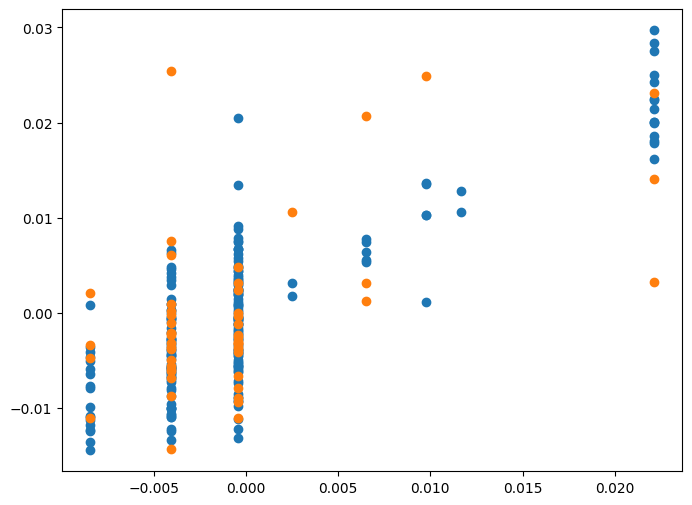

Raíz de la Pérdida cuadrática Entrenamiento: 0.004943078499921249
Raíz de la Pérdida cuadrática Prueba: 0.007495265454481469


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [34]:
# Gráfico de los valores predichos vs los verdaderos(entrenamiento y validación)

from matplotlib import pyplot as plt

# Usando la profundidad 3

decision_tree_Desempleo = DecisionTreeRegressor(max_depth=3)  #Creando el árbol con la profundidad anteriormente seleccionada - 4
decision_tree_Desempleo.fit(train_val_feature, train_val_target) #Entrenando el árbol

# Predicción de entrenamiento y test
train_val_prediction = decision_tree_Desempleo.predict(train_val_feature)
test_prediction = decision_tree_Desempleo.predict(test_feature)

# Gráfico de las predicciones vs los verdaderos(lo ideal sería una recta y=x)
plt.figure(figsize=(8, 6))
plt.scatter(train_val_prediction, train_val_target, label='train')  # Azul, indican la predicción vs el verdadero valor, pero del entrenamiento
plt.scatter(test_prediction, test_target, label='test')  # Naranja, , indican la predicción vs el verdadero valor, pero del test
plt.show()
print("Raíz de la Pérdida cuadrática Entrenamiento:",sklearn.metrics.mean_squared_error( train_val_prediction, train_val_target,squared=False))

print("Raíz de la Pérdida cuadrática Prueba:",sklearn.metrics.mean_squared_error(test_prediction, test_target,squared=False))

In [35]:
print(train_val_prediction.size)#Tamaño de las predicciones del conjunto de entrenamiento
print(train_val_target.size)

print(test_prediction.size)#Tamaño de las predicciones del conjunto de test
print(test_target.size)

211
211
52
52


In [36]:
indicetrian_val_test=df1_qpro.index #Seleccionando los índices
print(indicetrian_val_test.size)
indicetrain_val=indicetrian_val_test[0:211]#Seleccionando los índices del entrenamiento y validación
indicetest=indicetrian_val_test[211:263]#Seleccionando los índices del test

263


In [37]:
print(indicetrain_val.size)
print(indicetest.size)

211
52


In [38]:
targetjoint=np.concatenate((train_val_target,test_target))#Uniendo los verdaderos valores entrenamiento-validación con el test
predictionjoint=np.concatenate((train_val_prediction,test_prediction))#Uniendo las presicciones de entrenamiento-validación con test
print(targetjoint.size)
print(predictionjoint.size)

263
263


In [39]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_val_test)
ObsvsPred.head(10)#Recordemos que eliminamos las 12 primeras observaciones porque habían NA cuando organizamos los datos

observado  Predicción
2002-02-01  -0.005582   -0.000429
2002-03-01  -0.004149   -0.008429
2002-04-01   0.003744   -0.004069
2002-05-01  -0.004115   -0.000429
2002-06-01   0.003504   -0.000429
2002-07-01  -0.001861   -0.000429
2002-08-01   0.002016   -0.000429
2002-09-01  -0.006075   -0.004069
2002-10-01   0.002209   -0.000429
2002-11-01   0.000898   -0.004069

<Figure size 1000x600 with 0 Axes>

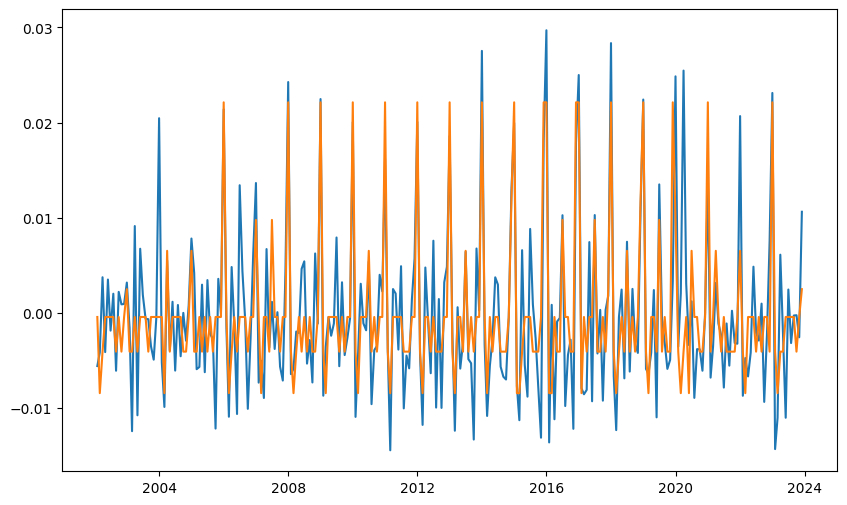

In [40]:
#Gráfico simple de lo observado y lo predicho
plt.figure(figsize=(10, 6))
plt.plot(ObsvsPred)

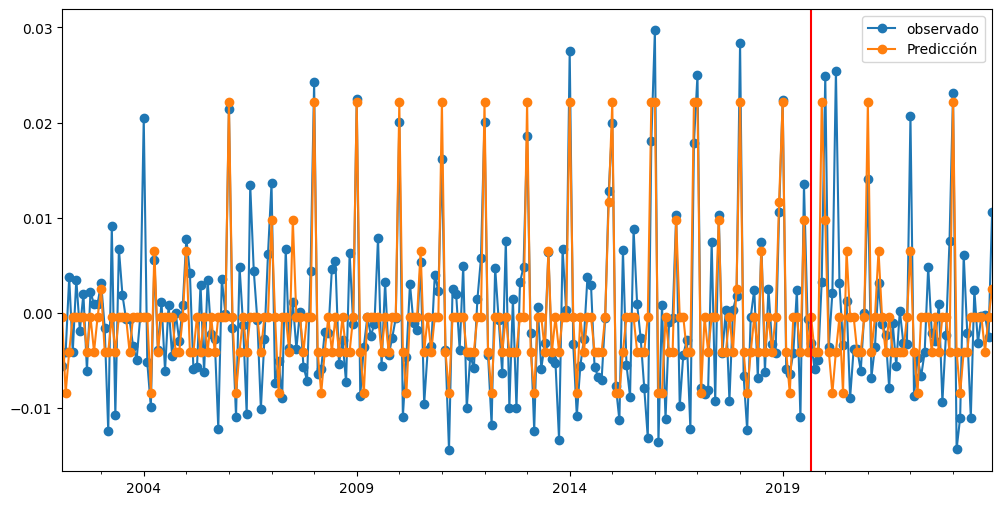

In [41]:
ax = ObsvsPred.plot( marker="o", figsize=(12,6))
ax.axvline(x=indicetrian_val_test[211].date(),color='red')

Comparación de las predicciones

In [42]:
#Haciendo como ejercicio la operación inversa de la diferencia ordinaria con mi serie original
serie_original_recuperada = DifeDesempleo.cumsum()
serie_original_recuperada = serie_original_recuperada.add(TranDesempleoTS.iloc[::-1].iloc[0], fill_value=0)
TranDesempleoTS.iloc[::-1]

AnioMes
2001-01-01    0.923352
2001-02-01    0.925986
2001-03-01    0.920449
2001-04-01    0.915123
2001-05-01    0.912902
                ...   
2023-08-01    0.878230
2023-09-01    0.877956
2023-10-01    0.877713
2023-11-01    0.875151
2023-12-01    0.885776
Name: DesempleoTransf, Length: 276, dtype: float64

In [43]:
DifeDesempleo

AnioMes
2001-01-01         NaN
2001-02-01    0.002634
2001-03-01   -0.005537
2001-04-01   -0.005327
2001-05-01   -0.002221
                ...   
2023-08-01   -0.003169
2023-09-01   -0.000274
2023-10-01   -0.000243
2023-11-01   -0.002562
2023-12-01    0.010625
Name: DesempleoTransf, Length: 276, dtype: float64

In [44]:
#Voy a hacer la evaluación de la predicción del testeo, lo que requiero hacer entonces es juntar las observaciones reales antes del periodo de testeo y juntar el testeo

Flipo=pd.Series(np.concatenate([DifeDesempleo.values[:224],test_prediction]))
Flipo                

0           NaN
1      0.002634
2     -0.005537
3     -0.005327
4     -0.002221
         ...   
271   -0.000429
272   -0.000429
273   -0.004069
274   -0.000429
275    0.002493
Length: 276, dtype: float64

In [45]:
#Primero junto las observaciones de enero de 2001 hasta enero de 2002 de la serie diferenciada con las predicciones
#InverArbol1 = pd.Series(np.concatenate([DifeDesempleo.values[:13],predictionjoint]), index=pd.date_range('2001-01-01', periods=276, freq='MS',normalize=True)) #Este está mal porque lo que hace es la predicción de toda la serie, es decir, también del entrenamiento
InverArbol1 = pd.Series(pd.Series(np.concatenate([DifeDesempleo.values[:224],test_prediction]), index=pd.date_range('2001-01-01', periods=276, freq='MS',normalize=True)))#Este en cambio solo lo hace con los datos originales y luego le pone las predicciones del test unicamente
#Haciendo la operación inversa de la diferenciación ordinaria con las predicciones del árbol
InverArbol1 = InverArbol1.cumsum()
InverArbol1 = InverArbol1.add(TranDesempleoTS.iloc[::-1].iloc[0],fill_value=0)
InverArbol1
#Finalmente realizo la operación inversa de la transformación de BoxCox con mis predicciones
from scipy.special import inv_boxcox
InverArbol1 = inv_boxcox(InverArbol1, BoxCoxStat[1])

2001-01-01    0.923352
2001-02-01    0.925986
2001-03-01    0.920449
2001-04-01    0.915123
2001-05-01    0.912902
                ...   
2023-08-01    0.872755
2023-09-01    0.872326
2023-10-01    0.868257
2023-11-01    0.867828
2023-12-01    0.870321
Freq: MS, Length: 276, dtype: float64

In [46]:
InverArbol1
DesempleoTS.iloc[::-1]

2001-01-01    16.622300
2001-02-01    17.434200
2001-03-01    15.811900
2001-04-01    14.515100
2001-05-01    14.035800
                ...    
2023-08-01     8.808063
2023-09-01     8.773311
2023-10-01     8.456961
2023-11-01     8.424948
2023-12-01     8.614498
Freq: MS, Length: 276, dtype: float64

AnioMes
2001-01-01    16.622300
2001-02-01    17.434200
2001-03-01    15.811900
2001-04-01    14.515100
2001-05-01    14.035800
                ...    
2023-08-01     9.277372
2023-09-01     9.252674
2023-10-01     9.230912
2023-11-01     9.007386
2023-12-01    10.013717
Name: TasaDesempleo, Length: 276, dtype: float64

Finalmente el gráfico comparando la serie de tiempo original con las predicciones hechas por el modelamiento con árboles, recordemos que las predicciones son hechas únicamente para febrero de 2002 en adelante

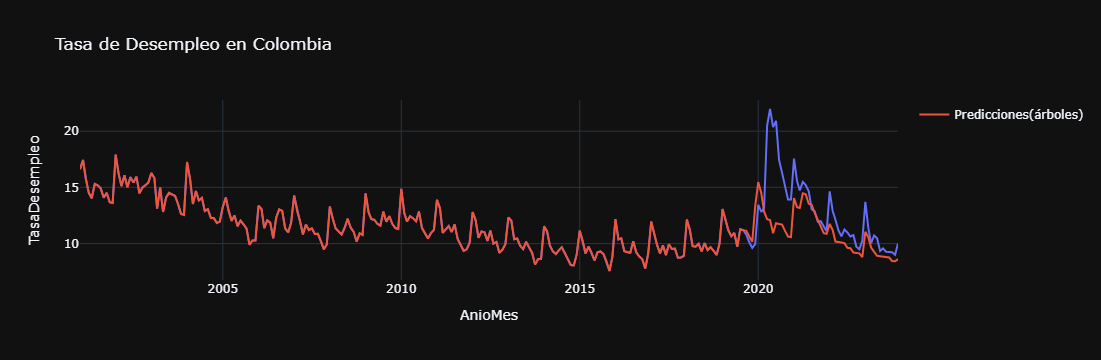

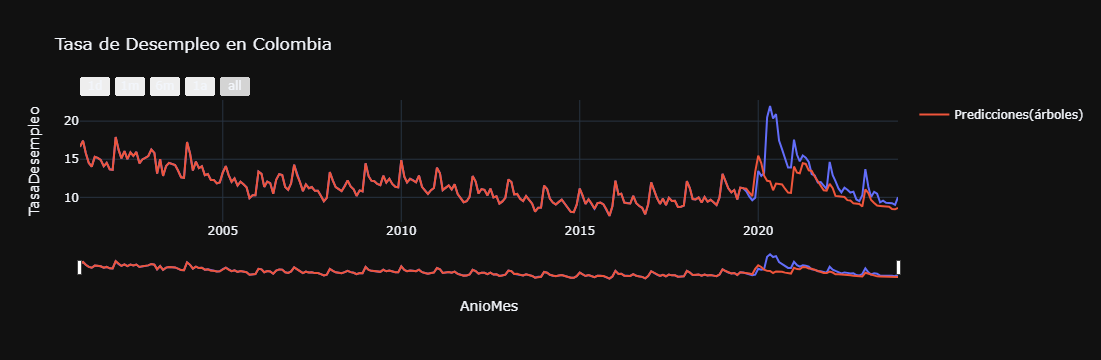

In [47]:
fig = px.line(DesempleoTS, y="TasaDesempleo", title="Tasa de Desempleo en Colombia", template='plotly_dark')  # Se le puede quitar el modo oscuro si quiere
fig.add_trace(go.Scatter(x=InverArbol1.index, y=InverArbol1, mode='lines', name='Predicciones(árboles)'))
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

El error cuadrático medio de estas predicciones es

In [48]:
sklearn.metrics.mean_squared_error(InverArbol1[-52:].values, DesempleoTS[:52][::-1].values,squared=False)
np.sqrt(((InverArbol1[-52:].values-DesempleoTS[:52][::-1].values)**2).mean())#Manualmente

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



3.1527056036345305

3.1527056036345305

## Modelando la serie original en lugar de la serie con tendencia extraída
Haremos nuevamente la disposición de los datos con la serie original


In [49]:
NuevaConf = pd.DataFrame(Data['TasaDesempleo'].iloc[::-1].values,index=pd.date_range(start='2001-01-01', end='2023-12-01', freq='MS') )
from pandas import DataFrame
df2 = DataFrame()#Creando un DataFrame vacío para luego llenar
for i in range(12,8,-1):
    df2[['t-'+str(i)]] = NuevaConf.shift(i)#El método shift() se encarga de desplazar las filas i veces hacia abajo
    
for i in range(6,1,-1):   
    df2[['t-'+str(i)]] = NuevaConf.shift(i)
df2['t'] = NuevaConf.values
df2 = df2[12:]
print(df2.head(10))

               t-12     t-11     t-10      t-9      t-6      t-5      t-4  \
2002-01-01  16.6223  17.4342  15.8119  14.5151  15.1838  14.9135  14.0741   
2002-02-01  17.4342  15.8119  14.5151  14.0358  14.9135  14.0741  14.5249   
2002-03-01  15.8119  14.5151  14.0358  15.3123  14.0741  14.5249  13.6822   
2002-04-01  14.5151  14.0358  15.3123  15.1838  14.5249  13.6822  13.6084   
2002-05-01  14.0358  15.3123  15.1838  14.9135  13.6822  13.6084  17.9099   
2002-06-01  15.3123  15.1838  14.9135  14.0741  13.6084  17.9099  16.1888   
2002-07-01  15.1838  14.9135  14.0741  14.5249  17.9099  16.1888  15.1114   
2002-08-01  14.9135  14.0741  14.5249  13.6822  16.1888  15.1114  16.0770   
2002-09-01  14.0741  14.5249  13.6822  13.6084  15.1114  16.0770  15.0221   
2002-10-01  14.5249  13.6822  13.6084  17.9099  16.0770  15.0221  15.9110   

                t-3      t-2        t  
2002-01-01  14.5249  13.6822  17.9099  
2002-02-01  13.6822  13.6084  16.1888  
2002-03-01  13.6084  17.9099  15

División entrenamiento y prueba

In [50]:
Split2 = df2.values #Convirtiendo en NumpyArray
X1_2= Split2[:, 0:-1] #Selecciono todas las filas, y todas las columnas excepto la última que es la variable respuesta
y1_2 =Split2[:,-1] #Selecciono todas las filas y solo la última columna 

In [51]:
X_train_full, X_test, y_train_full, y_test=train_test_split(X1_2,y1_2,test_size=0.2, train_size=0.8,shuffle=False)

División del entrenamiento en entrenamiento y validación (los porcentajes los seleccioné así para que quede similar a los porcentajes 70,10,20 del modelo de árboles)

In [52]:
X_train, X_val, y_train, y_val=train_test_split(X_train_full,y_train_full,test_size=0.12, train_size=0.88,shuffle=False)

Creamos el árbol nuevamente sin especificar la profundidad, por defecto se realizará un sobreajuste

In [53]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_Desempleo2 = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_Desempleo2.fit(X_train, y_train)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_Desempleo2.score(X_train, y_train))
print("Coeficiente R2 sobre el conjunto de Validación:",decision_tree_Desempleo2.score(X_val,y_val))  # predictions are horrible if negative value, no relationship if 0
print("el RECM sobre validación es:",(((decision_tree_Desempleo2.predict(X_val)-y_val)**2).mean()) )

DecisionTreeRegressor()

Coeficiente R2 sobre el conjunto de entrenamiento: 1.0
Coeficiente R2 sobre el conjunto de Validación: -0.5444122933246964
el RECM sobre validación es: 1.9116159374324417


Exploramos diferentes profundidades y evaluamos la raíz del Error Cuadrático Medio

In [54]:
for d in [2,3,4,5,6,7,8,9,10,11,12]:
    # Create the tree and fit it
    decision_tree_Desempleo2 = DecisionTreeRegressor(max_depth=d)
    decision_tree_Desempleo2.fit(X_train, y_train)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_Desempleo2.score(X_train, y_train))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_Desempleo2.score(X_val, y_val), '\n')  # You want the test score to be positive and high
    print("el RECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_Desempleo2.predict(X_val),y_val, squared=False))

DecisionTreeRegressor(max_depth=2)

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



max_depth= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7607346578842921
Coeficiente R2 sobre el conjunto de validación: 0.46955693561887235 

el RECM sobre el conjunto de validación es: 0.8102855312070419


DecisionTreeRegressor(max_depth=3)

max_depth= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.8475444008457279
Coeficiente R2 sobre el conjunto de validación: 0.4344652574937432 

el RECM sobre el conjunto de validación es: 0.8366587192600113


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=4)

max_depth= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.8910782679986445
Coeficiente R2 sobre el conjunto de validación: 0.37854647387041396 

el RECM sobre el conjunto de validación es: 0.8770473176389412


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=5)

max_depth= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9257898831118396
Coeficiente R2 sobre el conjunto de validación: 0.06695495082621128 

el RECM sobre el conjunto de validación es: 1.0746573238561048


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=6)

max_depth= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9478630644691074
Coeficiente R2 sobre el conjunto de validación: 0.0005870033310858558 

el RECM sobre el conjunto de validación es: 1.1122212612235658


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=7)

max_depth= 7
Coeficiente R2 sobre el conjunto de entrenamiento: 0.968614083283212
Coeficiente R2 sobre el conjunto de validación: -0.07379106345468567 

el RECM sobre el conjunto de validación es: 1.152865356855024


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=8)

max_depth= 8
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9841060312870077
Coeficiente R2 sobre el conjunto de validación: -0.2630978093849423 

el RECM sobre el conjunto de validación es: 1.250366090753519


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=9)

max_depth= 9
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9935159923462433
Coeficiente R2 sobre el conjunto de validación: -0.23933256600792463 

el RECM sobre el conjunto de validación es: 1.2385473866529666


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=10)

max_depth= 10
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9982392137286837
Coeficiente R2 sobre el conjunto de validación: -0.3660850416275534 

el RECM sobre el conjunto de validación es: 1.3003419227424053


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=11)

max_depth= 11
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9995091593295776
Coeficiente R2 sobre el conjunto de validación: -0.10428758763709722 

el RECM sobre el conjunto de validación es: 1.169121888980748


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



DecisionTreeRegressor(max_depth=12)

max_depth= 12
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9999869584092184
Coeficiente R2 sobre el conjunto de validación: -0.5009755806592742 

el RECM sobre el conjunto de validación es: 1.3630302984447207


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



La profundidad adecuada es 2 (extraño), pero vamos a utilizar otra vez 4 para obtener un resultado visual un poco mejor
## Hacemos el árbol con ambos conjuntos de datos

DecisionTreeRegressor(max_depth=4)

<Figure size 800x600 with 0 Axes>

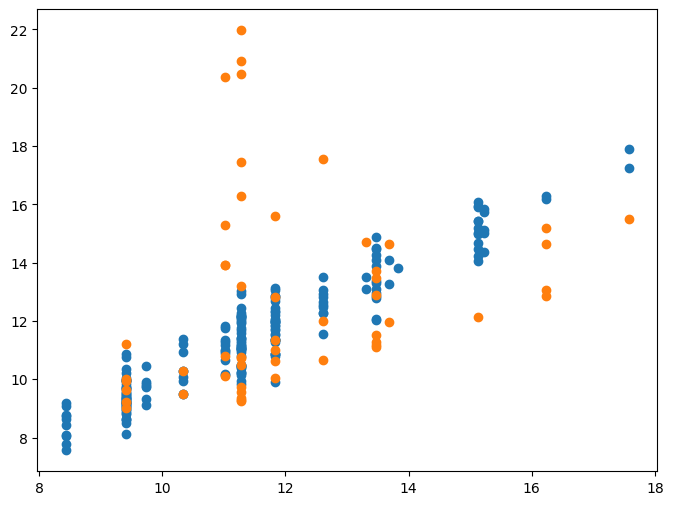

Raíz de la Pérdida cuadrática Entrenamiento: 0.6556115106604542
Raíz de la Pérdida cuadrática Prueba: 3.4159920024106274


C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [55]:
# Gráfico de los valores predichos vs los verdaderos(entrenamiento y validación)

from matplotlib import pyplot as plt

# Usando la profundidad 4

decision_tree_Desempleo2 = DecisionTreeRegressor(max_depth=4)  #Creando el árbol con la profundidad anteriormente seleccionada - 4
decision_tree_Desempleo2.fit(X_train_full, y_train_full) #Entrenando el árbol

# Predicción de entrenamiento y test
train_val_prediction2 = decision_tree_Desempleo2.predict(X_train_full)
test_prediction2 = decision_tree_Desempleo2.predict(X_test)

# Gráfico de las predicciones vs los verdaderos(lo ideal sería una recta y=x)
plt.figure(figsize=(8, 6))
plt.scatter(train_val_prediction2, y_train_full, label='train')  # Azul, indican la predicción vs el verdadero valor, pero del entrenamiento
plt.scatter(test_prediction2, y_test, label='test')  # Naranja, , indican la predicción vs el verdadero valor, pero del test
plt.show()
print("Raíz de la Pérdida cuadrática Entrenamiento:",sklearn.metrics.mean_squared_error( train_val_prediction2, y_train_full,squared=False))

print("Raíz de la Pérdida cuadrática Prueba:",sklearn.metrics.mean_squared_error(test_prediction2, y_test,squared=False))

264
264
264


observado  Predicción
2002-01-01    17.9099   17.583150
2002-02-01    16.1888   16.230150
2002-03-01    15.1114   15.217440
2002-04-01    16.0770   15.119017
2002-05-01    15.0221   15.119017
2002-06-01    15.9110   15.119017
2002-07-01    15.4261   15.119017
2002-08-01    15.9527   15.119017
2002-09-01    14.4655   15.119017
2002-10-01    14.9726   15.119017

<Figure size 1000x600 with 0 Axes>

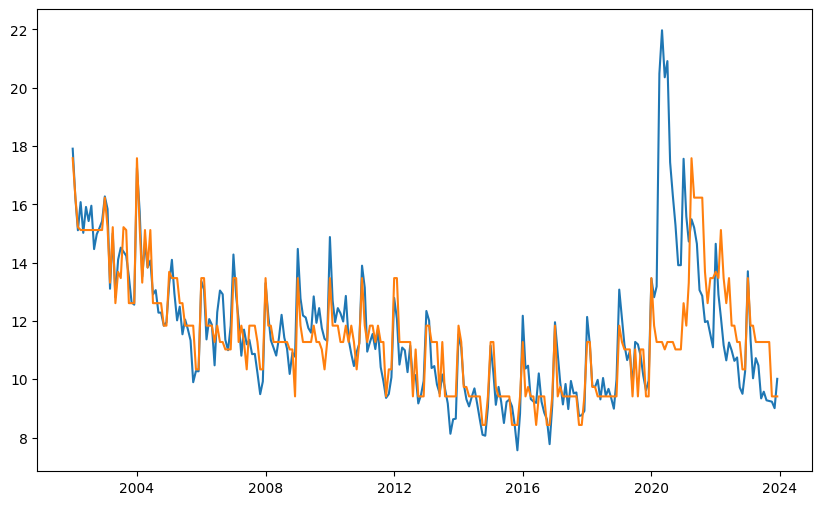

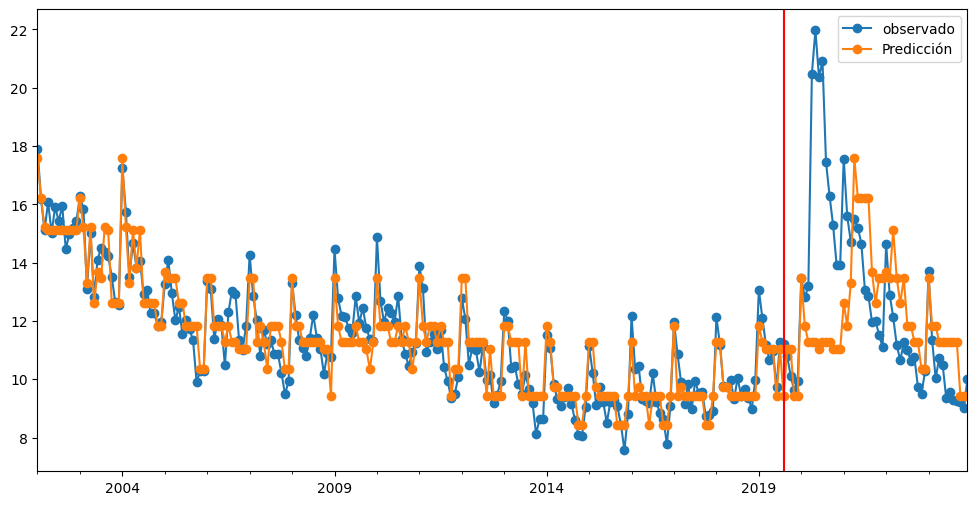

In [56]:
indicetrian_val_test2=df2.index #Seleccionando los índices
print(indicetrian_val_test2.size)
indicetrain_val2=indicetrian_val_test2[0:211]#Seleccionando los índices del entrenamiento y validación
indicetest2=indicetrian_val_test2[211:263]#Seleccionando los índices del test

targetjoint2=np.concatenate((y_train_full,y_test))#Uniendo los verdaderos valores entrenamiento-validación con el test
predictionjoint2=np.concatenate((train_val_prediction2,test_prediction2))#Uniendo las presicciones de entrenamiento-validación con test
print(targetjoint2.size)
print(predictionjoint2.size)
d2 = {'observado': targetjoint2, 'Predicción': predictionjoint2}
ObsvsPred2=pd.DataFrame(data=d2,index=indicetrian_val_test2)
ObsvsPred2.head(10)#Recordemos que eliminamos las 12 primeras observaciones porque habían NA cuando organizamos los datos
#Gráfico simple de lo observado y lo predicho
plt.figure(figsize=(10, 6))
plt.plot(ObsvsPred2)
ax = ObsvsPred2.plot( marker="o", figsize=(12,6))
ax.axvline(x=indicetrian_val_test2[211].date(),color='red')

Es un comportamiento un poco malo puesto que la profundidad del árbol fue de tan solo 2

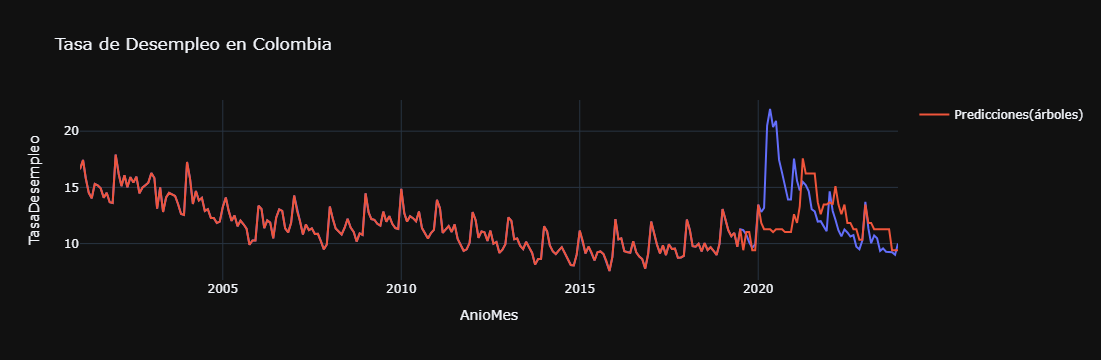

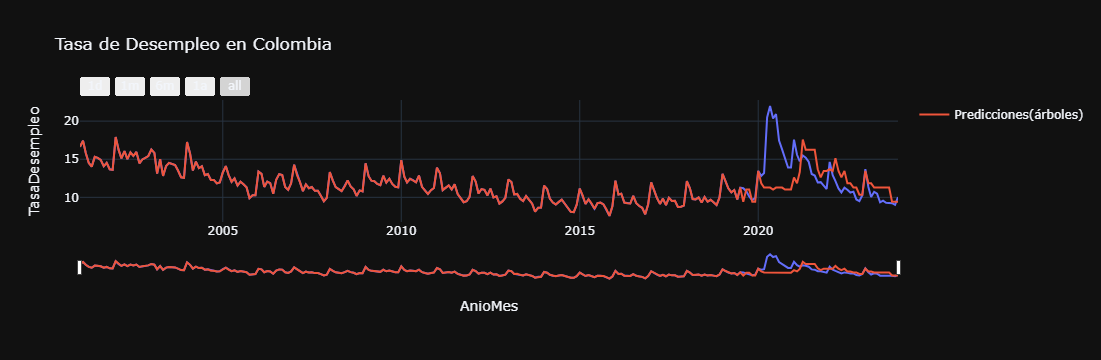

In [57]:
InverArbol2 = pd.Series(pd.Series(np.concatenate([DesempleoTS[::-1][:223].values,test_prediction2]), index=pd.date_range('2001-01-01', periods=276, freq='MS',normalize=True)))#En este caso no hay que hacer nada, simplemente poner los datos originales y las 52 predicciones
fig = px.line(DesempleoTS, y="TasaDesempleo", title="Tasa de Desempleo en Colombia", template='plotly_dark')  # Se le puede quitar el modo oscuro si quiere
fig.add_trace(go.Scatter(x=InverArbol2.index, y=InverArbol2, mode='lines', name='Predicciones(árboles)'))
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

Muy mal

# Modelamiento utilizando Redes Neuronales
## Redes Neuronales Multicapa(MLP)
A comparación de los modelos de árboles anteriores, en este apartado trabajaremos con los datos originales, por lo cual utilizaremos la división hecha con los datos originales.

### Estandarización de las covariables

In [58]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

Las respuestas no se estandarizan

### Red Neuronal con una sola capa
Recordemos que los hiperparámetros de una red neuronal multicapa son la cantidad de capas, los nodos que tiene cada capa y la función de activación.
Para crear las capas se utiliza [], y se separan con comas. En este caso, hay una sola capa oculta, y una de salida (*keras.layers.Dense(1)*)
* *layers.Dense* - layers indica que voy a añadir una nueva capa, .Dense, que esa capa será Densa
* 64 son la cantidad de nodos que hay dentro de esa primera capa oculta.
* activation="relu" indica que la función de activación es relu
* *input_shape=X_train.shape[1:]* son la cantidad de columnas que tiene nuestro dataframe, en este caso 9(escogimos 9 retardos)
* La capa de salida *keras.layers.Dense(1)* tiene un 1 debido a que nuestra variable respuesta es univariada

In [59]:
ModMLP1=keras.models.Sequential([keras.layers.Dense(64,activation="relu",input_shape=X_train.shape[1:]),keras.layers.Dense(1)])
ModMLP1.summary()

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

Utilizaremos el error cuadrático medio como métrica y el optimizador adam.
Además, realizaremos 50 épocas, junto a un tamaño de lote=12(por defecto es 32, entonces tendré 185/12 lotes, 185 porque hay 185 datos de entrenamiento

In [60]:
ModMLP1.compile(loss="mean_squared_error",optimizer="adam")
historyMod1=ModMLP1.fit(X_train,y_train,batch_size=12,epochs=50,validation_data=(X_val,y_val)) 

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 138.9773 - val_loss: 99.5211
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 131.2238 - val_loss: 94.1521
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 123.4534 - val_loss: 88.2696
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 107.2743 - val_loss: 81.2964
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 91.6786 - val_loss: 73.4175
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 80.6061 - val_loss: 64.9607
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 67.6664 - val_loss: 56.1399
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.0941 - val_loss: 47.5816
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 40.4575 - val_loss: 39.5118
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.6284 - val_loss: 32.2616
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21.0364 - val_loss: 26.1385
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

#### Comportamiento de la pérdida cuadrática en este conjunto de entrenamiento y validación

(185, 9)

<Axes: >

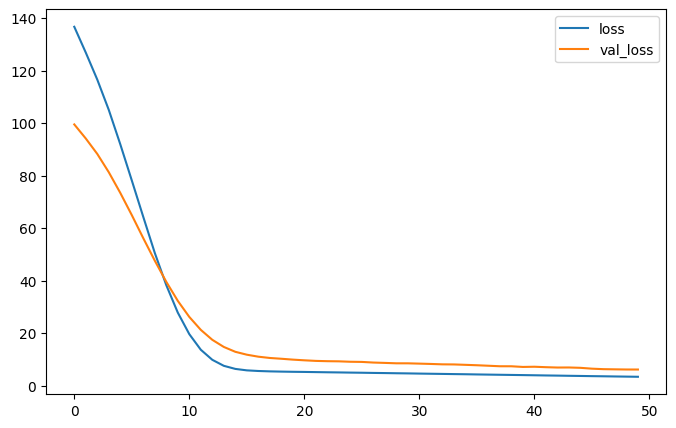

In [61]:
X_train.shape
pd.DataFrame(historyMod1.history).plot(figsize=(8,5))

In [62]:
mse_test1=ModMLP1.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 16.3594  


In [63]:
ypred1=ModMLP1.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


#### Gráfico de predicción y valores reales

<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'Tasa de Desempleo')

Text(0.5, 0, 'índice')

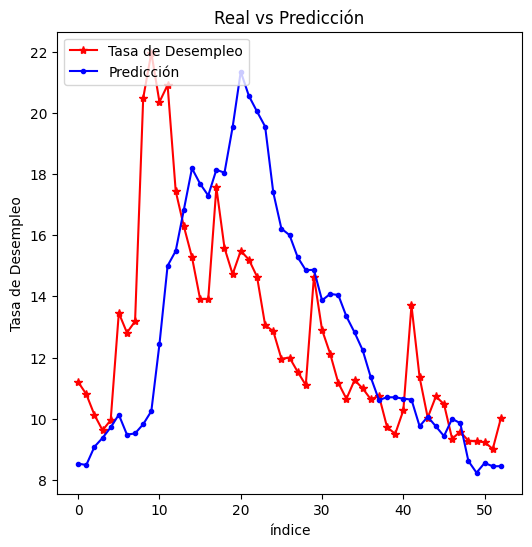

In [64]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred1.size), ypred1, linestyle='-', marker='.', color='b') 
plt.legend(['Tasa de Desempleo','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('Tasa de Desempleo')
plt.xlabel('índice')

No es un buen modelo prediciendo, no obstante, es entendible, puesto que el modelo intenta predecir la tasa de desempleo correspondiente al periodo de 2020 en adelante, el cual ya sabemos fue una época atípica para la humanidad. 

### Red neuronal con más capas
La anterior red neuronal contó con una sola capa oculta, la siguiente red contará con tres capas ocultas, de 64, 32, y 16 nodos respectivamente.
Utilizaremos la función de activación relu como la anterior, así como un tamaño de lote igual a 12 y 50 épocas.

In [65]:
input_layer = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(64,activation="relu")(input_layer)
hidden2 = keras.layers.Dense(32,activation="relu")(hidden1)
hidden3 = keras.layers.Dense(16,activation="relu")(hidden2)
output_layer = keras.layers.Dense(1, activation='linear')(hidden3)

In [66]:
ModMLP2=keras.Model(inputs=[input_layer],outputs=[output_layer])
ModMLP2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
print("Input shape:", X_train.shape)
print("Target shape:", y_train.shape)

Input shape: (185, 9)
Target shape: (185,)


In [68]:
ModMLP2.compile(loss="mean_squared_error",optimizer="adam")
historyMod2=ModMLP2.fit(X_train,y_train,epochs=50,batch_size=12,validation_data=(X_val,y_val))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 133.6193 - val_loss: 100.4144
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 132.3249 - val_loss: 95.7760
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 118.9382 - val_loss: 88.2392
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 104.3326 - val_loss: 75.3920
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 80.9632 - val_loss: 55.8287
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47.3677 - val_loss: 32.2010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.0208 - val_loss: 13.5916
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3707 - val_loss: 8.7323
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0588 - val_loss: 9.5113
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1997 - val_loss: 10.5197
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2515 - val_loss: 10.2336
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

<Axes: >

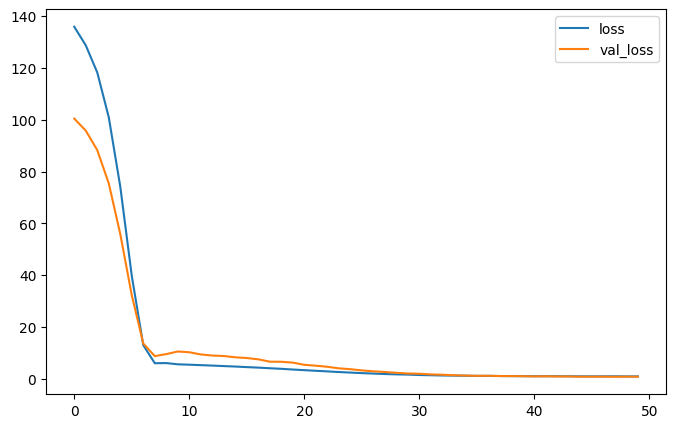

In [69]:
pd.DataFrame(historyMod2.history).plot(figsize=(8,5))

In [70]:
mse_test2=ModMLP2.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 10.8984  


In [71]:
100*(1-mse_test2/mse_test1)

33.01851232767717

El riesgo empírico ha disminuido un 35% aproximadamente con este nuevo modelo

In [72]:
ypred2=ModMLP2.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'Tasa de Desempleo')

Text(0.5, 0, 'índice')

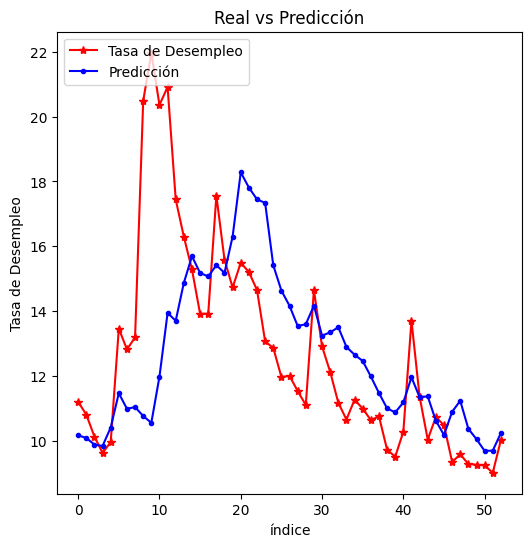

In [73]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred2.size), ypred2, linestyle='-', marker='.', color='b') 
plt.legend(['Tasa de Desempleo','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('Tasa de Desempleo')
plt.xlabel('índice')

Las predicciones mejoran a comparación del modelo anterior, en especial en los meses más recientes, el periodo correspondiente al 2020, como es de esperar, tiene una sub-estimación.

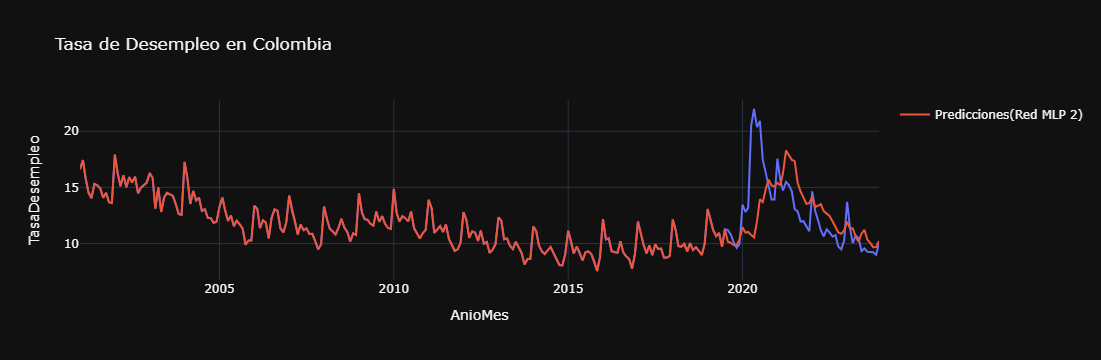

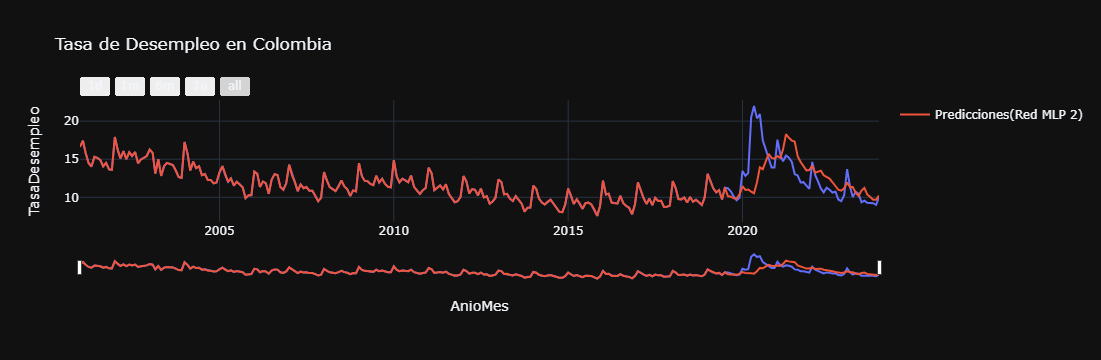

In [74]:
#Voy a ver toda la serie, es igual que el gráfico anterior, las predicciones únicamente van a partir de Agosto de 2019
Sipo1 = pd.Series(pd.Series(np.concatenate([DesempleoTS[::-1][:223].values,ypred2.flatten()]), index=pd.date_range('2001-01-01', periods=276, freq='MS',normalize=True)))
fig = px.line(DesempleoTS, y="TasaDesempleo", title="Tasa de Desempleo en Colombia", template='plotly_dark')  # Se le puede quitar el modo oscuro si quiere
fig.add_trace(go.Scatter(x=Sipo1.index, y=Sipo1, mode='lines', name='Predicciones(Red MLP 2)'))
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

### Paradigma 2
A comparación del anterior modelamiento, en esta ocasión, utilizaremos la configuración de datos realizada en la modelación con árboles, es decir, modelaremos inicialmente la serie sin tendencia, posterior a eso, añadiremos la tendencia y transformaremos nuevamente los datos mediante la transformación inversa de Box-Cox.

In [75]:
scaler2=MinMaxScaler()
X_train2=scaler2.fit_transform(train_feature)
X_val2=scaler2.transform(val_feature)
X_test2=scaler2.transform(test_feature)
y_train2=train_target
y_val2=val_target
y_test2=test_target

C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4401e-04 - val_loss: 3.9502e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6551e-04 - val_loss: 3.4976e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1526e-04 - val_loss: 2.9371e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8333e-04 - val_loss: 2.4898e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6333e-04 - val_loss: 2.1843e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2558e-04 - val_loss: 1.8854e-04
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2325e-04 - val_loss: 2.6864e-04
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4532e-04 - val_loss: 2.0497e-04
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1724e-04 - val_loss: 1.5664e-04
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2061e-05 - val_loss: 1.6

<Axes: >

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000162006C5440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5899e-04 


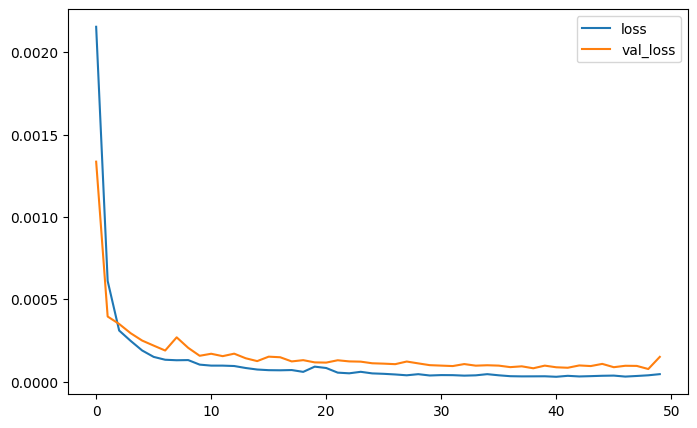

In [76]:
#Modelo de una sola capa
ModMLP3=keras.models.Sequential([keras.layers.Dense(64,activation="relu",input_shape=X_train2.shape[1:]),keras.layers.Dense(1)])
ModMLP3.summary()

ModMLP3.compile(loss="mean_squared_error",optimizer="adam")
historyMod3=ModMLP3.fit(X_train2,y_train2,batch_size=12,epochs=50,validation_data=(X_val2,y_val2)) 

pd.DataFrame(historyMod3.history).plot(figsize=(8,5))

ypred3=ModMLP3.predict(X_test2)
mse_test3=ModMLP3.evaluate(X_test2,y_test2)

<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'Tasa de Desempleo')

Text(0.5, 0, 'índice')

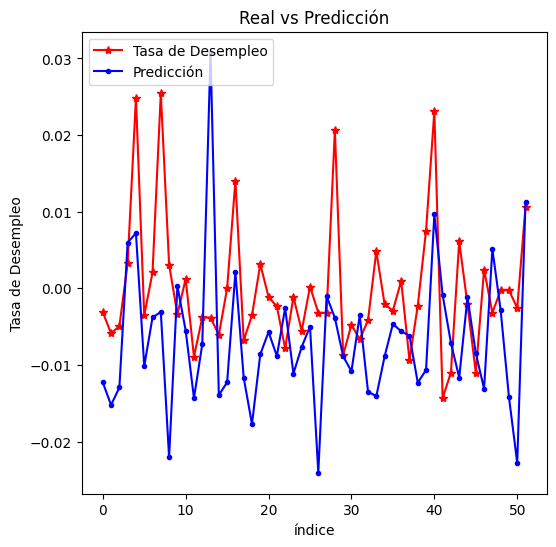

In [77]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test2.size), y_test2, linestyle='-', marker='*', color='r')
plt.plot(range(ypred3.size), ypred3, linestyle='-', marker='.', color='b') 
plt.legend(['Tasa de Desempleo','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('Tasa de Desempleo')
plt.xlabel('índice')

In [78]:
#PredMLP3=np.concatenate((ModMLP3.predict(X_train2),ModMLP3.predict(X_val2),ypred3))
#Primero junto las observaciones de enero de 2001 hasta enero de 2002 de la serie diferenciada con las predicciones
#InverMLP1 = pd.Series(np.concatenate([DifeDesempleo.values[:13], PredMLP3.flatten()]), index=pd.date_range('2001-01-01', periods=276, freq='MS', normalize=True))
InverMLP1 = pd.Series(pd.Series(np.concatenate([DifeDesempleo.values[:224],ypred3.flatten()]), index=pd.date_range('2001-01-01', periods=276, freq='MS',normalize=True)))#Este en cambio solo lo hace con los datos originales y luego le pone las predicciones del test unicamente
#Haciendo la operación inversa de la diferenciación ordinaria con las predicciones de la red de una capa
InverMLP1 = InverMLP1.cumsum()
InverMLP1 = InverMLP1.add(TranDesempleoTS.iloc[::-1].iloc[0],fill_value=0)
InverMLP1
#Finalmente realizo la operación inversa de la transformación de BoxCox con mis predicciones
from scipy.special import inv_boxcox
InverMLP1 = inv_boxcox(InverMLP1, BoxCoxStat[1])

2001-01-01    0.923352
2001-02-01    0.925986
2001-03-01    0.920449
2001-04-01    0.915123
2001-05-01    0.912902
                ...   
2023-08-01    0.574726
2023-09-01    0.571871
2023-10-01    0.557695
2023-11-01    0.534897
2023-12-01    0.546168
Freq: MS, Length: 276, dtype: float64

In [79]:
InverMLP1
DesempleoTS.iloc[::-1]

2001-01-01    16.622300
2001-02-01    17.434200
2001-03-01    15.811900
2001-04-01    14.515100
2001-05-01    14.035800
                ...    
2023-08-01     2.377387
2023-09-01     2.361060
2023-10-01     2.283228
2023-11-01     2.168380
2023-12-01     2.223661
Freq: MS, Length: 276, dtype: float64

AnioMes
2001-01-01    16.622300
2001-02-01    17.434200
2001-03-01    15.811900
2001-04-01    14.515100
2001-05-01    14.035800
                ...    
2023-08-01     9.277372
2023-09-01     9.252674
2023-10-01     9.230912
2023-11-01     9.007386
2023-12-01    10.013717
Name: TasaDesempleo, Length: 276, dtype: float64

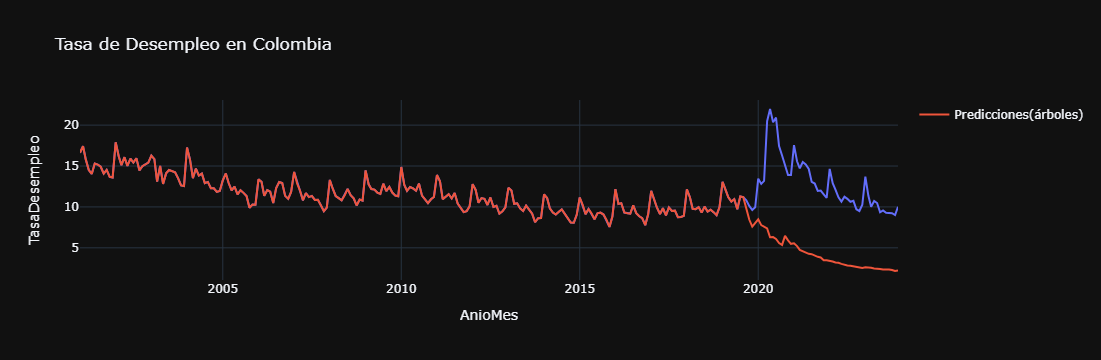

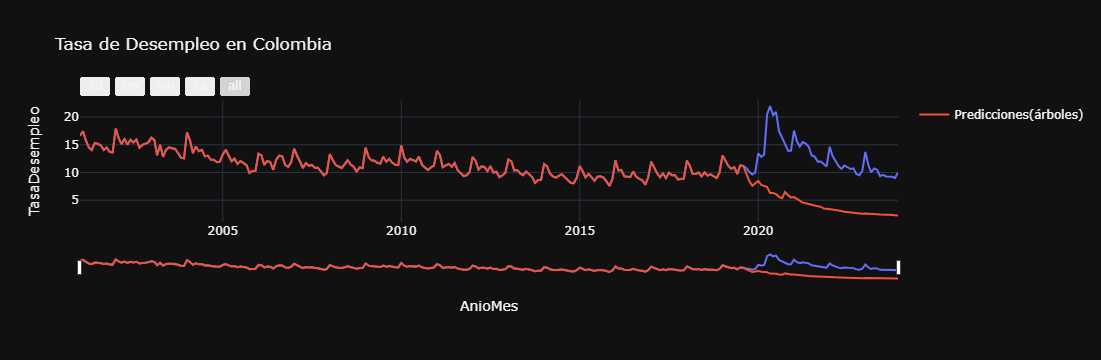

In [80]:
fig = px.line(DesempleoTS, y="TasaDesempleo", title="Tasa de Desempleo en Colombia", template='plotly_dark')  # Se le puede quitar el modo oscuro si quiere
fig.add_trace(go.Scatter(x=InverMLP1.index, y=InverMLP1, mode='lines', name='Predicciones(árboles)'))
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1a", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

Es un modelo bastante malo

In [81]:
#Modelo de 3 capas
input_layer_2 = keras.layers.Input(shape=X_train2.shape[1:])
hidden1_2 = keras.layers.Dense(64,activation="relu")(input_layer_2)
hidden2_2 = keras.layers.Dense(32,activation="relu")(hidden1_2)
hidden3_2 = keras.layers.Dense(16,activation="relu")(hidden2_2)
output_layer_2 = keras.layers.Dense(1, activation='linear')(hidden3_2)

In [82]:
ModMLP4=keras.Model(inputs=[input_layer_2],outputs=[output_layer_2])
ModMLP4.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
ModMLP4.compile(loss="mean_squared_error",optimizer="adam")
historyMod4=ModMLP4.fit(X_train2,y_train2,epochs=50,batch_size=12,validation_data=(X_val2,y_val2))

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0037 - val_loss: 5.8107e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1017e-04 - val_loss: 1.0875e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6760e-04 - val_loss: 8.7073e-05
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1663e-04 - val_loss: 1.0035e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2384e-05 - val_loss: 9.2793e-05
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2864e-05 - val_loss: 8.4730e-05
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6789e-05 - val_loss: 7.4699e-05
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2451e-05 - val_loss: 6.5210e-05
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7193e-05 - val_loss: 6.5504e-05
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3876e-05 - val_loss: 6.7047e-05
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7922e-05 - val_loss

<Axes: >

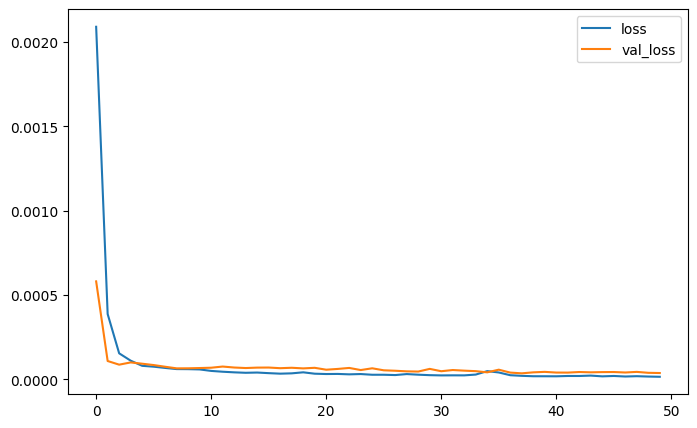

In [84]:
pd.DataFrame(historyMod4.history).plot(figsize=(8,5))

In [85]:
mse_test4=ModMLP4.evaluate(X_test2,y_test2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 8.8295e-05  


In [86]:
100*(1-mse_test3/mse_test4)

-96.15229570243527

In [87]:
ypred4=ModMLP4.predict(X_test2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


<Figure size 600x600 with 0 Axes>

Text(0.5, 1.0, 'Real vs Predicción')

Text(0, 0.5, 'Tasa de Desempleo')

Text(0.5, 0, 'índice')

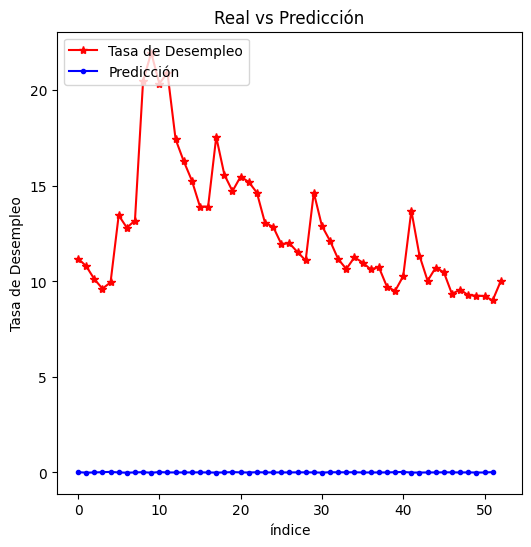

In [88]:
plt.figure(figsize=(6, 6))
plt.plot(range(y_test.size), y_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred4.size), ypred4, linestyle='-', marker='.', color='b') 
plt.legend(['Tasa de Desempleo','Predicción'], loc=2)
plt.title('Real vs Predicción')
plt.ylabel('Tasa de Desempleo')
plt.xlabel('índice')

No continuaré, es en general un modelo bastante malo, en conclusión se debe modelar con los datos originales.

### Búsqueda de los hiperparámetros

In [89]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=64, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=64, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2,step=0.003)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

<Sequential name=sequential_2, built=False>

In [117]:
tuner_GridSearch_mlp = kt.GridSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=None,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xed in position 12: invalid continuation byte

In [85]:
tuner_GridSearch_mlp.search_space_summary()

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.003, 'sampling': 'linear'}


In [86]:
stop_early=keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)

In [87]:
tuner_GridSearch_mlp.search(X_train,y_train, epochs=20, validation_data=(X_val,y_val),callbacks=[stop_early])

Trial 240 Complete [00h 00m 04s]
val_loss: 2.6713883876800537

Best val_loss So Far: 0.9785410761833191
Total elapsed time: 00h 13m 41s


In [88]:
# Get the top 2 models.
models_mlp = tuner_GridSearch_mlp.get_best_models(num_models=2)
best_model_mlp = models_mlp[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
# best_model_mlp.build(input_shape=(32, 1, 7))
# best_model_mlp.summary()

C:\Users\EQUIPO\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 



#### Los mejores 10 modelos

In [90]:
tuner_GridSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0202 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 1
units_0: 64
dropout: True
lr: 0.004
units_1: 32
Score: 0.9785410761833191

Trial 0077 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 1
units_0: 64
dropout: True
lr: 0.007
units_1: 64
Score: 0.9802599549293518

Trial 0209 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 2
units_0: 32
dropout: False
lr: 0.001
units_1: 64
Score: 1.0295199155807495

Trial 0200 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 1
units_0: 64
dropout: True
lr: 0.001
units_1: 32
Score: 1.0429284572601318

Trial 0201 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 1
units_0: 64
dropout: True
lr: 0.001
units_1: 64
Score: 1.0481157302856445

Trial 0217 summary
Hyperparameters:
num_units: 64
activation: tanh
num_layers: 2
units_0: 32
dropout: T

### Modelo final
Finalmente se entrenará el mejor modelo con los datos de entrenamiento y validación.

In [91]:
callback=keras.callbacks.EarlyStopping(monitor="loss",patience=5)
best_hps_mlp = tuner_GridSearch_mlp.get_best_hyperparameters(2)
model_mlp = build_model(best_hps_mlp[0])
# Fit with the entire dataset.
model_mlp.fit(X_train_full,y_train_full, epochs=50,callbacks=[callback])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 87.0564 - mean_squared_error: 87.0564    
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1021 - mean_squared_error: 9.1021 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1260 - mean_squared_error: 5.1260 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 5.8077 - mean_squared_error: 5.8077
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7662 - mean_squared_error: 4.7662 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4157 - mean_squared_error: 5.4157 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8662 - mean_squared_error: 4.8662 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 5.2733 - mean_squared_error: 5.2733
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 5.3855 - mean_squared_error: 5.3855
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7326 - mean_squared_error: 4.7326 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.87

In [92]:
model_mlp.layers[0].get_weights()[0]

array([[-5.21623865e-02, -2.95344383e-01,  2.73184955e-01,
        -5.67958839e-02, -2.42664352e-01,  2.68248171e-01,
        -2.53922403e-01, -1.11652158e-01,  2.12664694e-01,
        -4.43327352e-02, -1.73252612e-01,  2.39214435e-01,
         2.17266485e-01, -1.76956356e-01, -8.07386339e-02,
         5.90301603e-02, -1.01072460e-01,  1.89774767e-01,
        -1.03226975e-02,  2.86018252e-02, -5.07025756e-02,
        -6.14551976e-02, -1.88601180e-03,  9.71946418e-02,
        -2.81860858e-01, -1.60391018e-01,  1.59713104e-02,
        -2.10940167e-01,  2.56376974e-02,  1.07738905e-01,
        -7.93293491e-02,  1.86466694e-01,  8.59703124e-02,
        -7.58197010e-02,  1.84391931e-01,  4.41232063e-02,
        -1.53747886e-01, -8.48191679e-02, -1.64071217e-01,
        -1.52791113e-01,  2.79402941e-01, -1.95673719e-01,
         5.08992411e-02, -1.30618112e-02,  3.73496972e-02,
        -1.43298700e-01, -6.98446110e-02, -3.94802950e-02,
        -1.32600874e-01,  3.11532021e-02, -1.91658959e-0

In [93]:
print(model_mlp.layers[0].bias.numpy())

[ 0.01294254 -0.03590047  0.0366554  -0.04659821 -0.04461031  0.
  0.28810284  0.14411731 -0.03959979 -0.04635273  0.02817104  0.03211451
  0.03844969 -0.0250187  -0.01192902  0.19527052 -0.09467643  0.03622072
 -0.14387809  0.         -0.0336758   0.23538691 -0.03991164  0.21432073
 -0.03400126  0.09080861 -0.04159848  0.05055024 -0.21197155 -0.02357117
 -0.03572732  0.03744164 -0.03758176 -0.1615973  -0.02344702 -0.0368013
  0.14359212  0.03717646  0.0377669  -0.0582681   0.03795933 -0.03214179
 -0.06561671 -0.02368539  0.04082552  0.03500721  0.15135884 -0.04155943
 -0.1666843   0.          0.18029982  0.0360628  -0.07709499 -0.3115854
  0.06121644  0.01953105  0.01508419 -0.03154323 -0.2187926   0.02661806
 -0.06127229  0.01095328 -0.0103575   0.03790851]


In [94]:
X_test.shape

(53, 9)

In [95]:
prediction_test=model_mlp.predict( X_test, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [96]:
y_test=y_test.reshape((y_test.shape[0], 1))

In [97]:
errors_squared=keras.metrics.mean_squared_error(y_test, prediction_test).numpy()
print("RECM:",errors_squared.mean()**0.5)

RECM: 7.008698372362436


Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

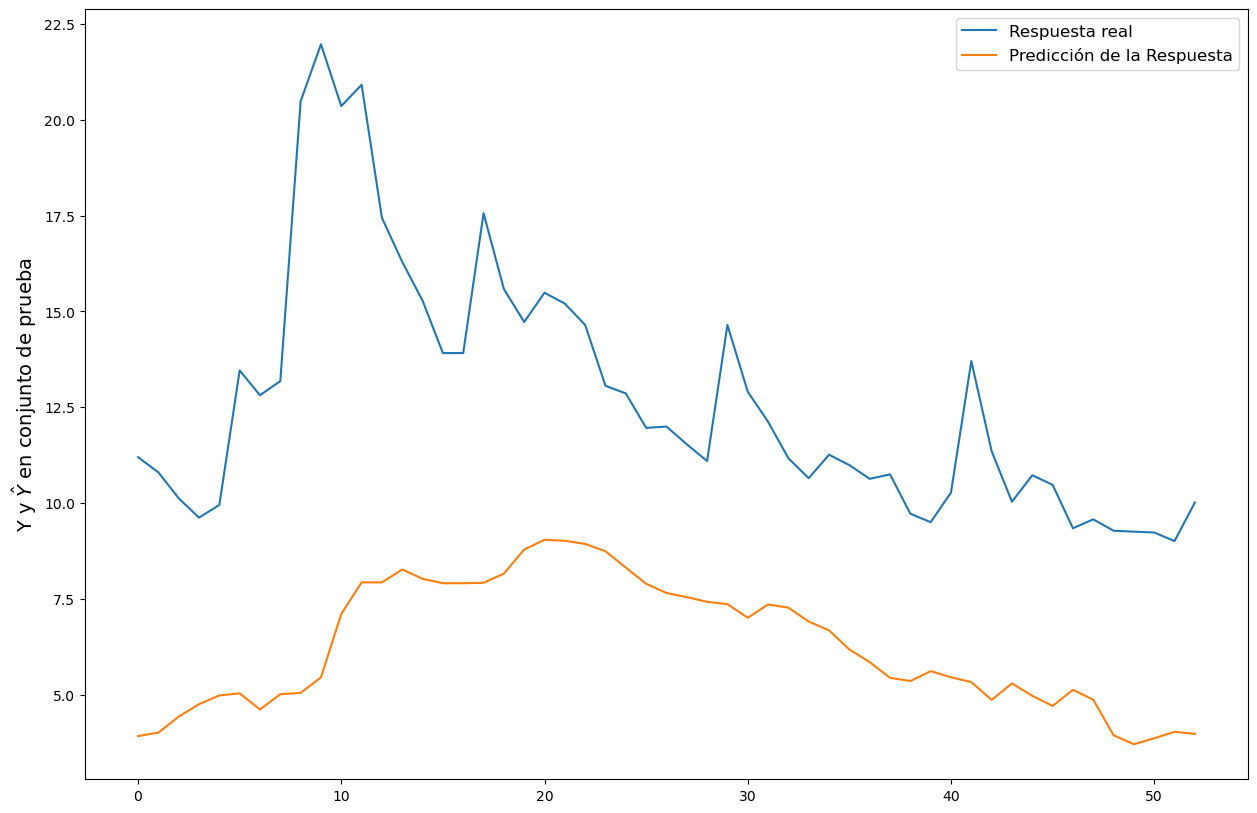

In [98]:
plt.plot(y_test)
plt.plot(prediction_test)
plt.legend(['Respuesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

Text(0, 0.5, '$\\hat{e}$ en conjunto de prueba')

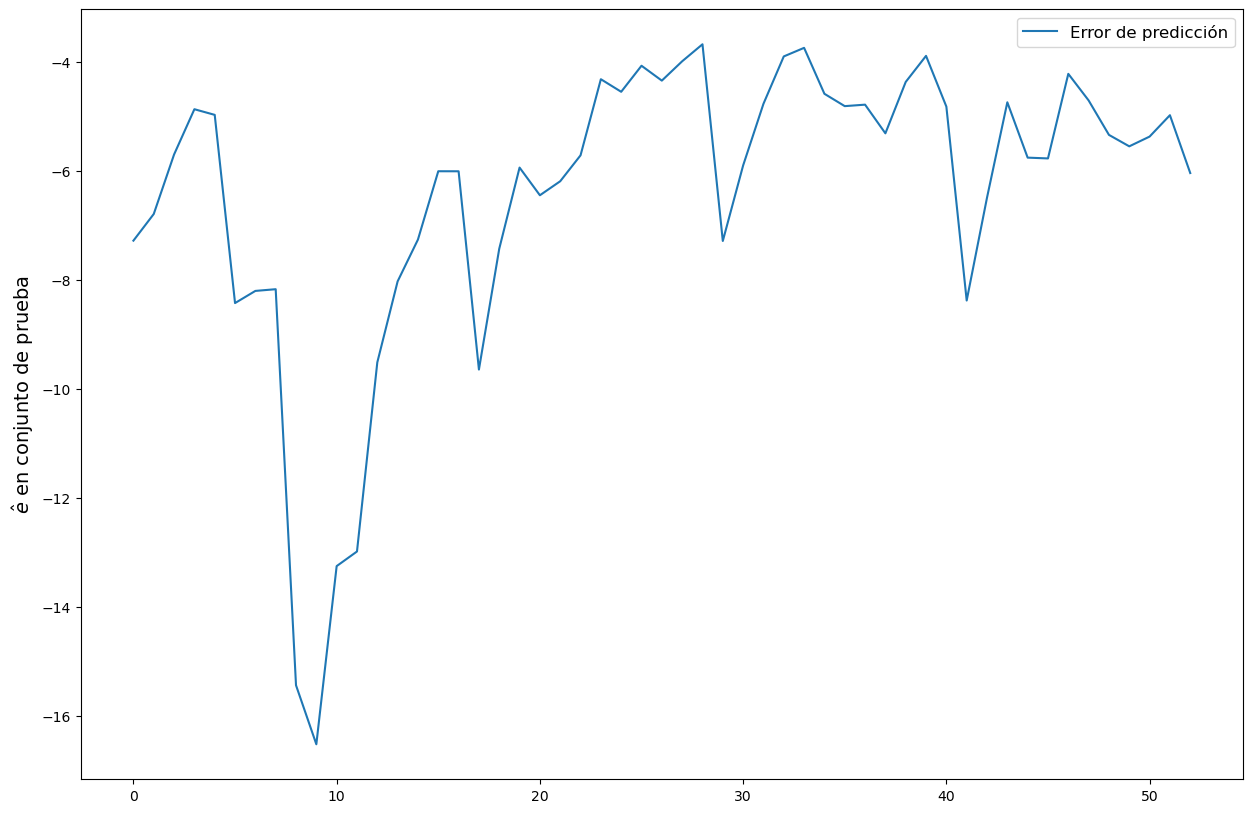

In [99]:
#Gráfico de errores
plt.plot(prediction_test-y_test)
plt.legend(['Error de predicción'],loc="best", fontsize=12)
plt.ylabel('$\hat{e}$ en conjunto de prueba', fontsize=14)

## Redes neuronales recurrentes (RNN)
Implementaremos tres redes recurrentes, una simple, una GRU y una LSTM.

In [90]:
X_train_full.shape

(211, 9)

In [91]:
#Modifiqué en el argumento input_shape x_train.shape[0] porque mis datos están configurados de forma diferente, pero es lo mismo, al del profe
def SimpleRNN_(n_units = 10, l1_reg=0, seed=1729):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[0], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=1729):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[0], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=1729):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[0], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [92]:
max_epochs = 100 #Definimos 100 épocas
batch_size = 12# Mantenemos el tamaño del batch

Si el riesgo empírico(MSE) no cambia con el paso de las épocas, el algoritmo se detendrá al paso de 10 épocas.

In [93]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)

In [94]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

#### Validación cruzada
A comparación del anterior modelamiento, usaremos validación cruzada ahora

In [95]:
do_training = True # Set to True if you wish to train your own models

In [96]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [99]:
X_train_full

array([[16.6223, 17.4342, 15.8119, ..., 14.0741, 14.5249, 13.6822],
       [17.4342, 15.8119, 14.5151, ..., 14.5249, 13.6822, 13.6084],
       [15.8119, 14.5151, 14.0358, ..., 13.6822, 13.6084, 17.9099],
       ...,
       [ 9.9795,  9.3085, 10.0423, ..., 13.0752, 12.0926, 11.1814],
       [ 9.3085, 10.0423,  9.4292, ..., 12.0926, 11.1814, 10.6566],
       [10.0423,  9.4292,  9.6707, ..., 11.1814, 10.6566, 10.9519]])

In [98]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(X_train_full, y_train_full, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
[CV] END

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 925, in _fit
    X, y = self._initialize(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 862, in _initialize
    self.model_ = self._build_keras_model()
                  ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\JUAN DAVID\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\scikeras\wrappers.py", line 433, in _build_keras_model
    model = final_build_fn(**build_params)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\JUAN DAVID\AppData\Local\Temp\ipykernel_26260\736034519.py", line 4, in SimpleRNN_
    model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[0], x_train.shape[-1]), unroll=True, stateful=False))
                                                                                                                                                                                                                                                                                                               ^^^^^^^
NameError: name 'x_train' is not defined


In [108]:
print(X_train.shape)  # Output: (n,)

# Obtener el tipo de datos (dtype) de los elementos de y_train
print(X_train.dtype)  # Output: dtype('int64') (o el tipo de datos correspondiente)

# Obtener el número total de elementos en y_train
print(X_train.size)  # Output: n (donde n es el número total de elementos en y_train)

# Obtener el número de dimensiones de y_train
print(X_train.ndim)  # Output: 1 (si y_train es un vector)

(185, 9)
float64
1665
2
